In [13]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import sys
import pandas as pd
import geopandas as gpd
import xarray as xr
import io, requests
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator)
import glob
from string import ascii_lowercase as alc

import scipy.stats as stats

from matplotlib.patches import Rectangle

### Just to remove warnings to prettify the notebook. 
import warnings
warnings.filterwarnings("ignore")

In [2]:
### consts
path_to_ccm_results = './data/processed/'

In [3]:
eco_regions = ['Middle Rockies',
               'Klamath Mountains',
               'Sierra Nevada',
               'Wasatch and Uinta Mountains',
               'Southern Rockies',
               'Idaho Batholith',
               'Columbia Mountains/Northern Rockies',
               'Canadian Rockies',
               'North Cascades',
               'Blue Mountains',
               'Cascades',
               'Eastern Cascades Slopes and Foothills',
               'Central Basin and Range',
               'Arizona/New Mexico Mountains',
               'Northern Basin and Range']

# coast_ecos = ['Klamath Mountains',
#               'Columbia Mountains/Northern Rockies',
#               'Canadian Rockies',
#               'North Cascades',
#               'Cascades',
#               'Eastern Cascades Slopes and Foothills']

coast_ecos = ['North Cascades',
              'Cascades',
              'Eastern Cascades Slopes and Foothills',
              'Columbia Mountains/Northern Rockies'
              ]


nocoast_ecos = ['Middle Rockies',
                'Sierra Nevada',
                'Southern Rockies',
                'Blue Mountains',
                'Central Basin and Range',
                'Northern Basin and Range']

In [4]:
# read in NA ECO_LEVEL 3 raster files
gdf = gpd.read_file('../data/NA_CEC_Eco_Level3/')

wus_eco = gdf[gdf['NA_L3NAME'].isin(eco_regions)]

In [5]:
wus_eco2 = gdf[gdf['NA_L3NAME'].isin(coast_ecos)]

In [6]:
# Define the CartoPy CRS object.
crs = ccrs.PlateCarree(central_longitude=180)

# This can be converted into a `proj4` string/dict compatible with GeoPandas
crs_proj4 = crs.proj4_init
wus_eco = wus_eco.to_crs(crs_proj4)

---

In [7]:
ccm_results_flist = np.sort(glob.glob(path_to_ccm_results+'*.nc'))

In [8]:
ccm_results_flist[5]

'./data/processed/ccm_SST_tau_1.nc'

In [9]:
alc[0]

'a'

In [10]:
pub_dir = '/Users/hkim139/Documents/research/03.manuscripts/2024/swe_causal_manuscript/figs_erl/'

Eco-regions for figure:
1. Canadian Rockies
2. Cascades
3. Columbia Mountains
4. Eastern Cascades
5. Klamath
6. North Cascades

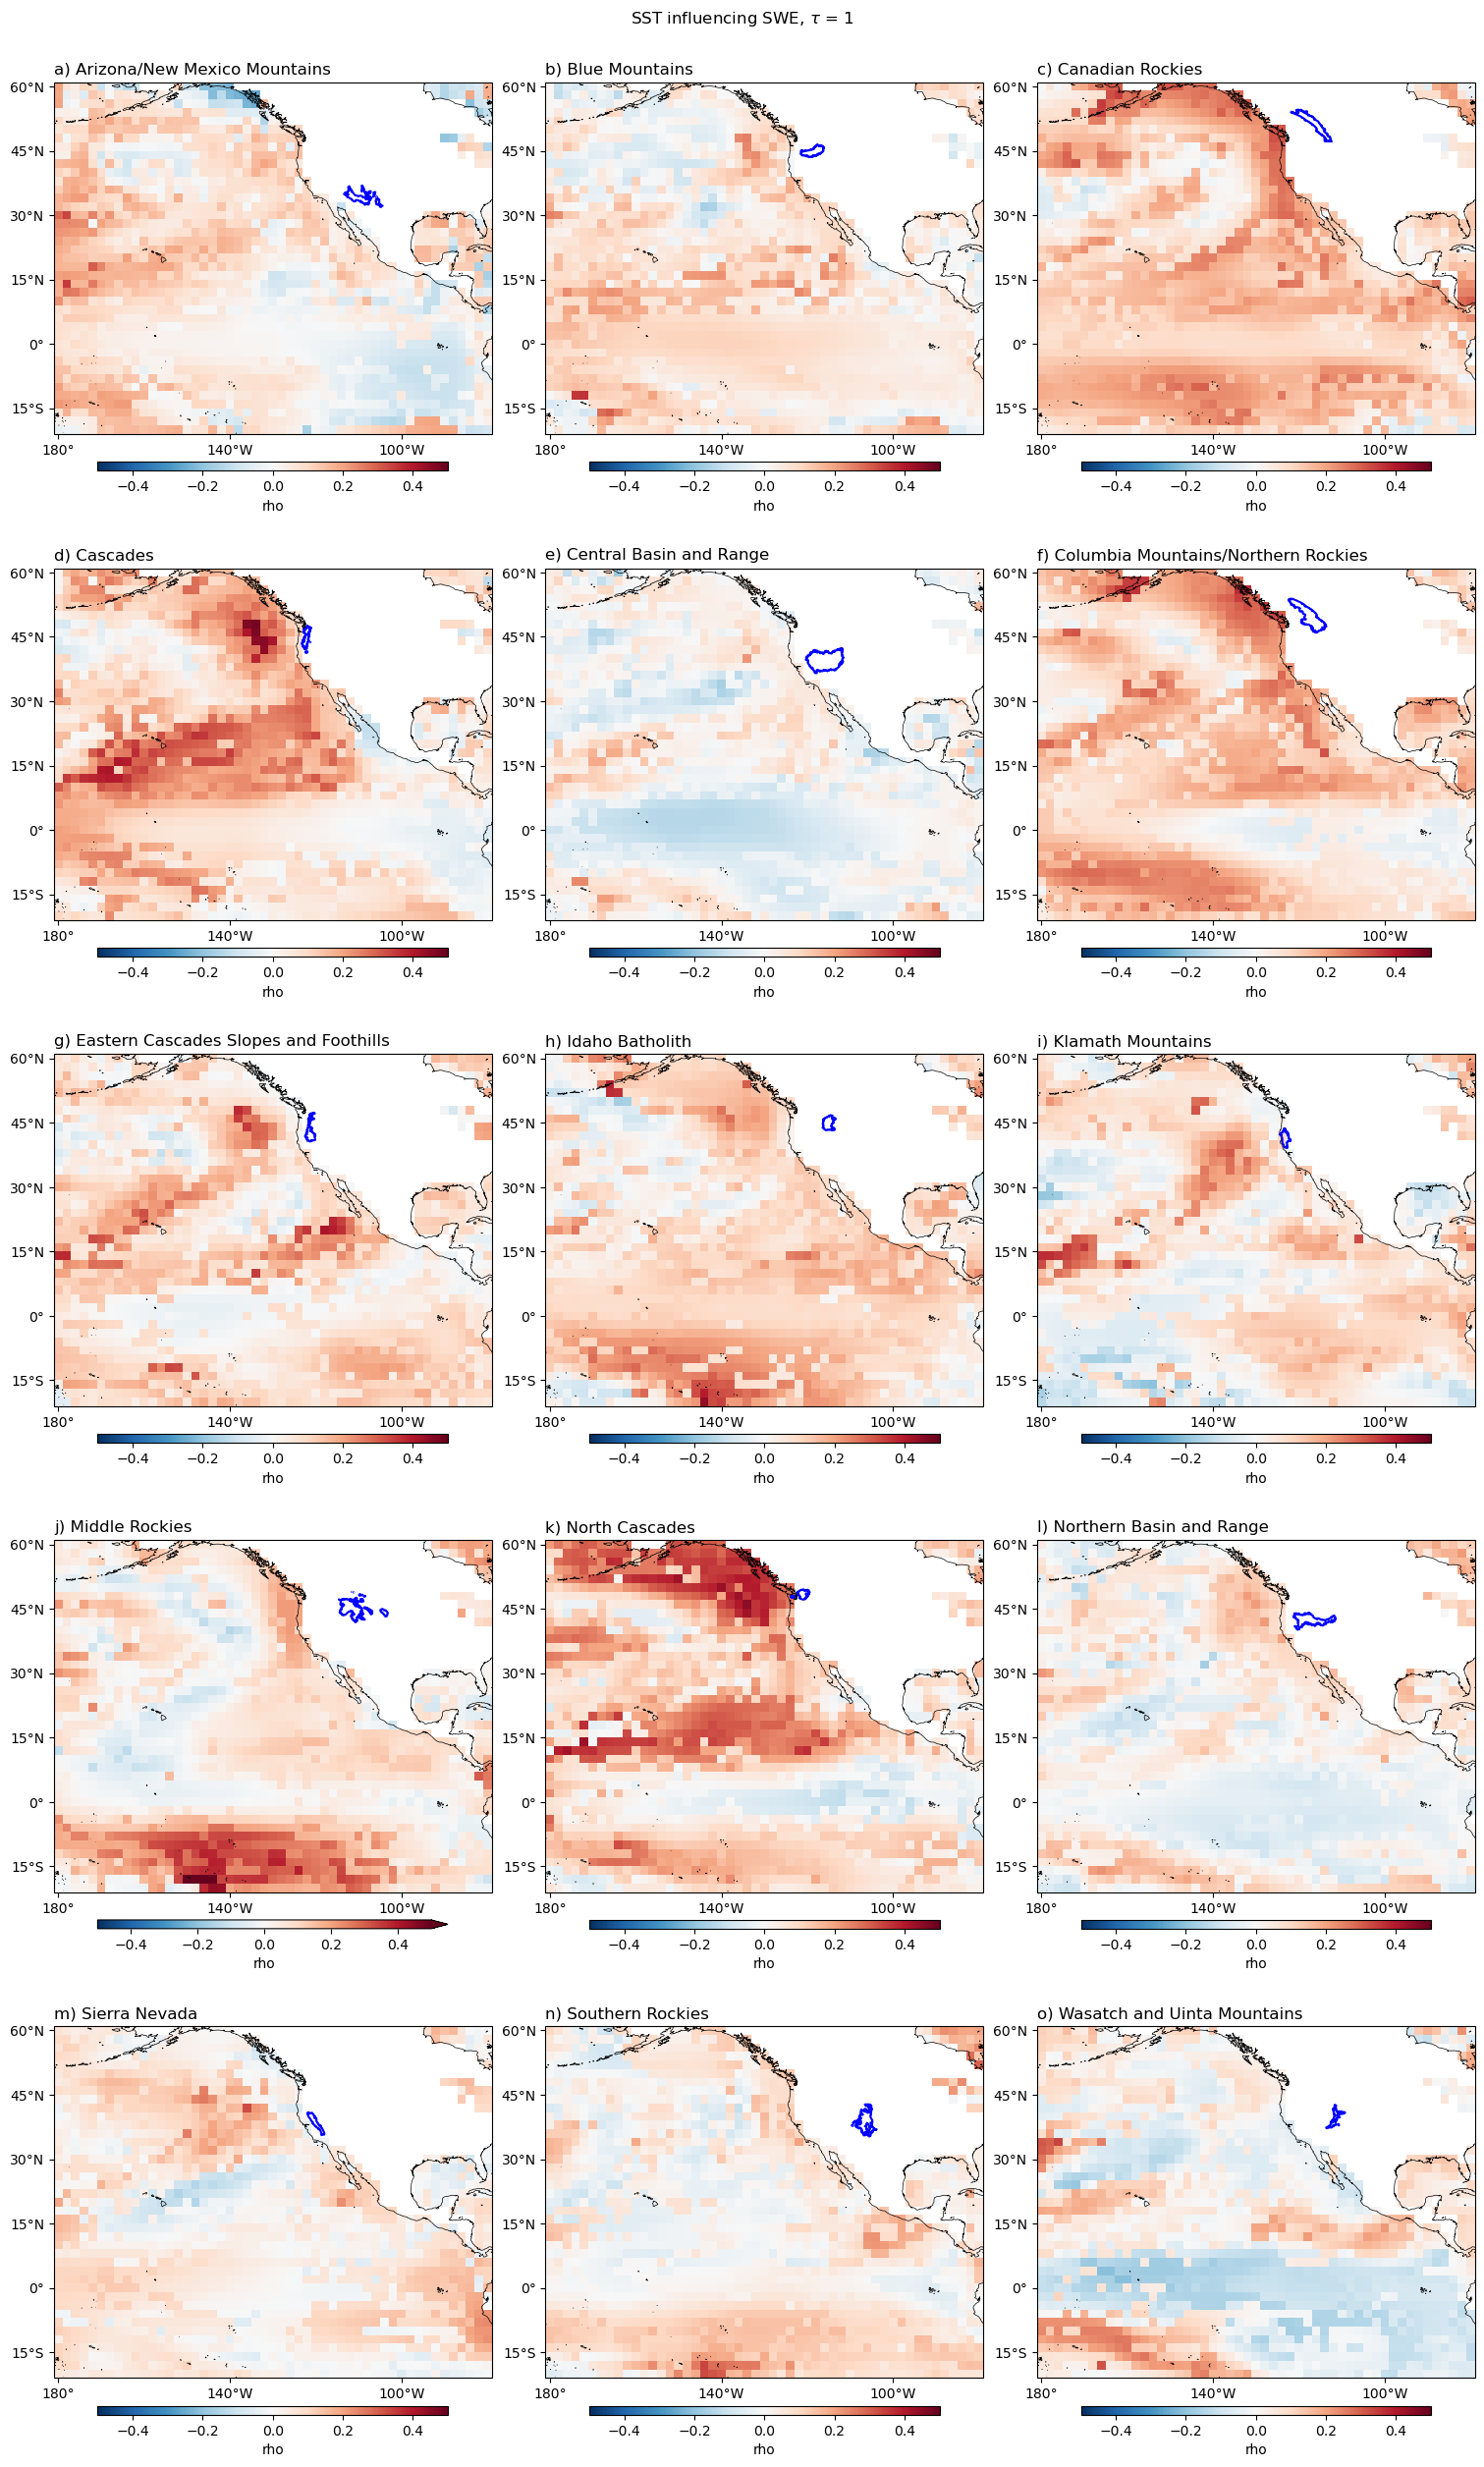

In [11]:
# def plot_ccm(f):
f = ccm_results_flist[5]

lag = f.split('_')[3].split('.')[0]
ccm_xr = xr.open_dataset(f)
fig = plt.figure(figsize=(15, 25), constrained_layout=True)
# create gridspec
gs = fig.add_gridspec(5,3, height_ratios=[1,1,1,1,1],
                      width_ratios=[1,1,1])

cbar_kwargs = {'shrink':0.8, 'aspect':40,
               'orientation':'horizontal', 'pad':0.01}

for i in range(15):
    eco_name = str(ccm_xr.isel(eco_region=i).eco_region.values)
    sub = wus_eco[wus_eco['NA_L3NAME']==eco_name]
    
    ax = fig.add_subplot(gs[i],
                         projection=ccrs.PlateCarree(central_longitude=180))
    ax.coastlines(resolution='50m', color='black', linewidth=0.5)
    ccm_xr.isel(eco_region=i).rho.plot(ax=ax,                                       
                                       cmap='RdBu_r',
                                       vmin=-0.5, vmax=0.5,
                                       transform=ccrs.PlateCarree(),
                                       cbar_kwargs=cbar_kwargs)
    sub.boundary.plot(ax=ax, color='b')
    ax.set_title('')
    ax.set_title('{}) {}'.format(alc[i], eco_name), loc='left')
    ax.set_xticks([180, 220, 260], crs=ccrs.PlateCarree())
    ax.set_yticks([-15, 0, 15, 30, 45, 60], crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.set_ylabel('')
    ax.set_xlabel('')
plt.suptitle(fr'SST influencing SWE, $\tau$ = {lag}')
# plt.savefig('./figs/ccm_sst_swe_lag3.png', bbox_inches='tight', facecolor='w')
plt.show()

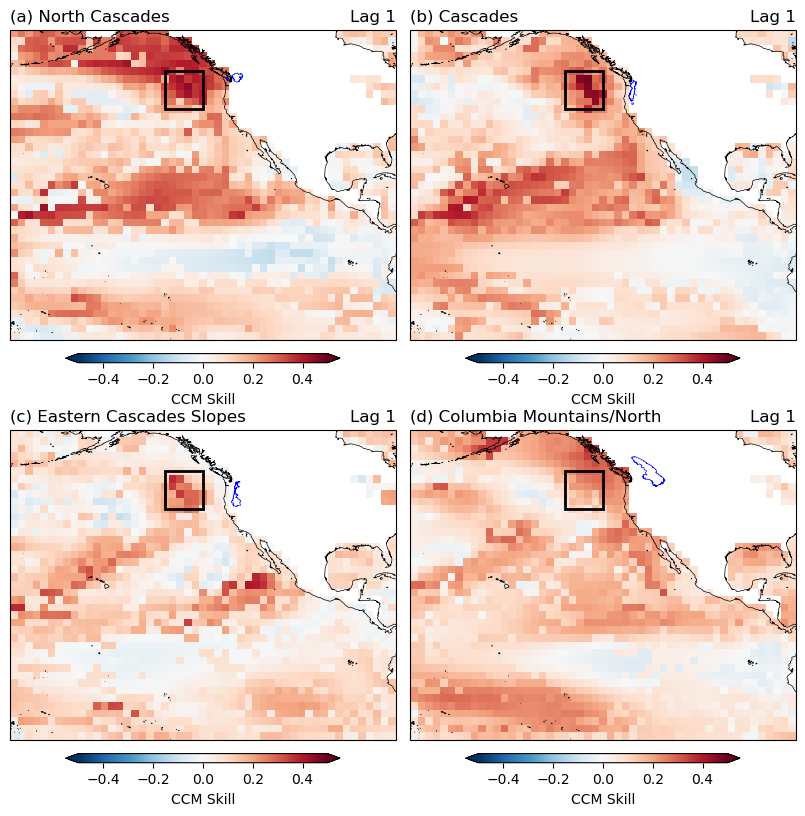

In [19]:
# def plot_ccm(f):
f = ccm_results_flist[5]

lag = f.split('_')[3].split('.')[0]
ccm_xr = xr.open_dataset(f)
fig = plt.figure(figsize=(8, 8), constrained_layout=True)
# create gridspec
gs = fig.add_gridspec(2,2, height_ratios=[1,1],
                      width_ratios=[1,1])

cbar_kwargs = {'shrink':0.7, 'aspect':30,
               'orientation':'horizontal', 'pad':0.04,
               'extend': 'both', 'label': 'CCM Skill'}

for i in range(len(coast_ecos)):
    eco_name = str(ccm_xr.sel(eco_region=coast_ecos[i]).eco_region.values)
    sub = wus_eco[wus_eco['NA_L3NAME']==eco_name]
    
    ax = fig.add_subplot(gs[i],
                         projection=ccrs.PlateCarree(central_longitude=180))
    ax.coastlines(resolution='50m', color='black', linewidth=0.5)
    ccm_xr.sel(eco_region=coast_ecos[i]).rho.plot(ax=ax,
                                       cmap='RdBu_r',
                                       vmin=-0.5, vmax=0.5,
                                       transform=ccrs.PlateCarree(),
                                       cbar_kwargs=cbar_kwargs)
    sub.boundary.plot(ax=ax, color='b', linewidth=0.5)
    ax.set_title('')
    ax.set_title('({}) {:.24s}'.format(alc[i], eco_name), loc='left', fontsize=12)
    ax.set_title('Lag {}'.format(lag), loc='right', fontsize=12)

    rect = Rectangle((220,40),10,10,
                 edgecolor='k', facecolor='None', transform=ccrs.PlateCarree(), lw=2)
    ax.add_patch(rect)
    
    # ax.set_xticks([180, 220, 260], crs=ccrs.PlateCarree())
    # ax.set_yticks([-15, 0, 15, 30, 45, 60], crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.set_ylabel('')
    ax.set_xlabel('')
# plt.suptitle(fr'SST influencing SWE, Lag = {lag}', fontsize=14)
plt.savefig(pub_dir+'fig2a_2d.eps',
            bbox_inches='tight',
            facecolor='w')
plt.show()

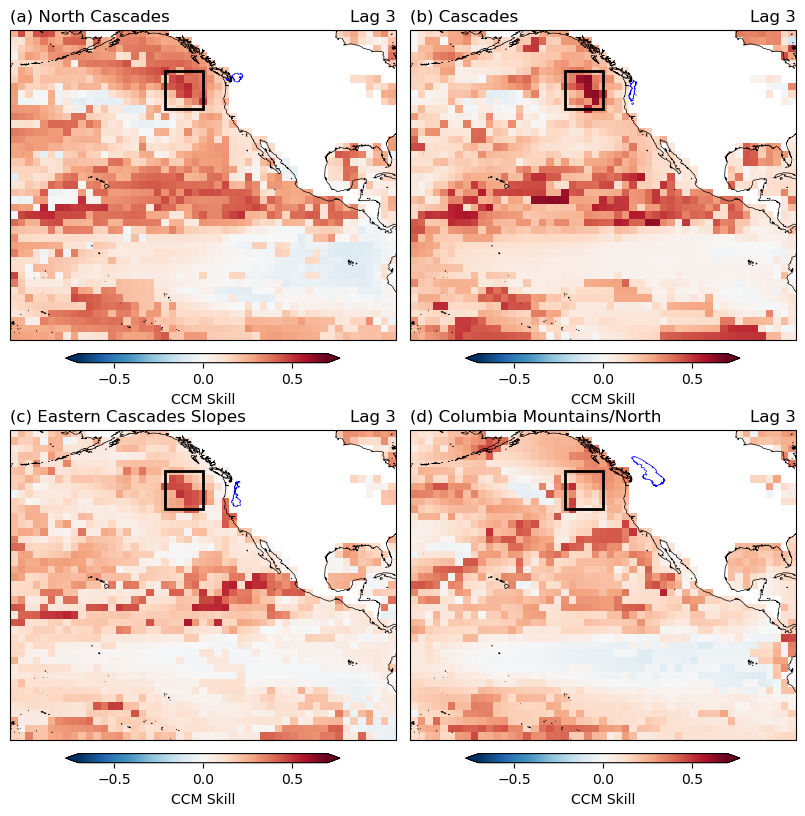

In [20]:
# def plot_ccm(f):
f = ccm_results_flist[6]

lag = f.split('_')[3].split('.')[0]
ccm_xr = xr.open_dataset(f)
fig = plt.figure(figsize=(8, 8), constrained_layout=True)
# create gridspec
gs = fig.add_gridspec(2,2, height_ratios=[1,1],
                      width_ratios=[1,1])

cbar_kwargs = {'shrink':0.7, 'aspect':30,
               'orientation':'horizontal', 'pad':0.04,
               'extend': 'both', 'label': 'CCM Skill'}

for i in range(len(coast_ecos)):
    eco_name = str(ccm_xr.sel(eco_region=coast_ecos[i]).eco_region.values)
    sub = wus_eco[wus_eco['NA_L3NAME']==eco_name]
    
    ax = fig.add_subplot(gs[i],
                         projection=ccrs.PlateCarree(central_longitude=180))
    ax.coastlines(resolution='50m', color='black', linewidth=0.5)
    ccm_xr.sel(eco_region=coast_ecos[i]).rho.plot(ax=ax,
                                       cmap='RdBu_r',
                                       vmin=-0.7, vmax=0.7,
                                       transform=ccrs.PlateCarree(),
                                       cbar_kwargs=cbar_kwargs)
    sub.boundary.plot(ax=ax, color='b', linewidth=0.5)
    ax.set_title('')
    ax.set_title('({}) {:.24s}'.format(alc[i], eco_name), loc='left', fontsize=12)
    ax.set_title('Lag {}'.format(lag), loc='right', fontsize=12)

    rect = Rectangle((220,40),10,10,
                 edgecolor='k', facecolor='None', transform=ccrs.PlateCarree(), lw=2)
    ax.add_patch(rect)
    
    # ax.set_xticks([180, 220, 260], crs=ccrs.PlateCarree())
    # ax.set_yticks([-15, 0, 15, 30, 45, 60], crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.set_ylabel('')
    ax.set_xlabel('')
# plt.suptitle(fr'SST influencing SWE, Lag = {lag}', fontsize=14)
plt.savefig(pub_dir+'fig3a_3d.eps',
            bbox_inches='tight',
            facecolor='w')
plt.show()

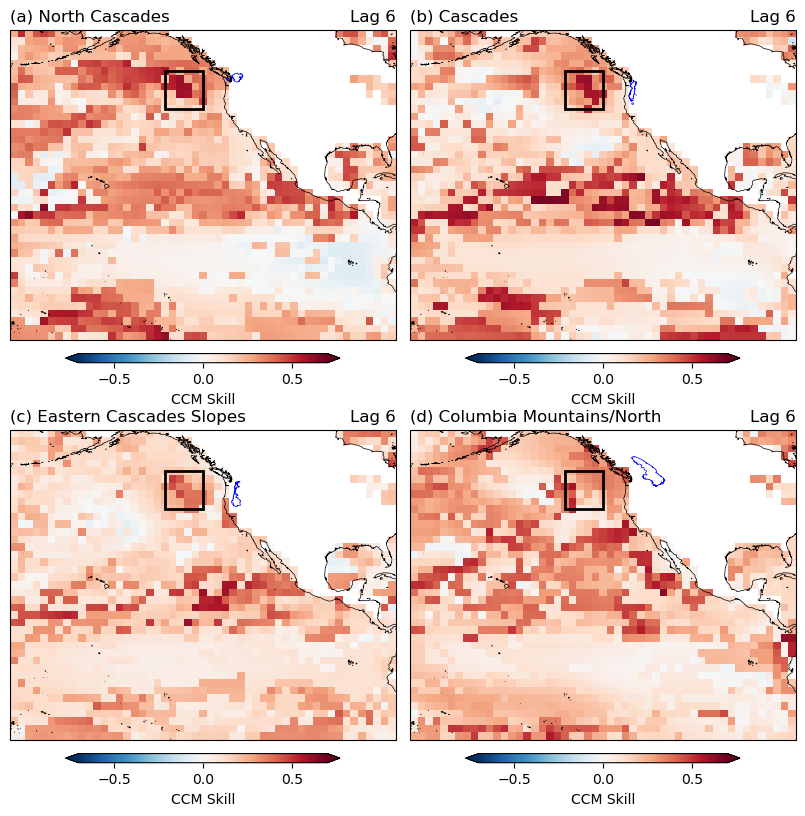

In [21]:
# def plot_ccm(f):
f = ccm_results_flist[7]

lag = f.split('_')[3].split('.')[0]
ccm_xr = xr.open_dataset(f)
fig = plt.figure(figsize=(8, 8), constrained_layout=True)
# create gridspec
gs = fig.add_gridspec(2,2, height_ratios=[1,1],
                      width_ratios=[1,1])

cbar_kwargs = {'shrink':0.7, 'aspect':30,
               'orientation':'horizontal', 'pad':0.04,
               'extend': 'both', 'label': 'CCM Skill'}

for i in range(len(coast_ecos)):
    eco_name = str(ccm_xr.sel(eco_region=coast_ecos[i]).eco_region.values)
    sub = wus_eco[wus_eco['NA_L3NAME']==eco_name]
    
    ax = fig.add_subplot(gs[i],
                         projection=ccrs.PlateCarree(central_longitude=180))
    ax.coastlines(resolution='50m', color='black', linewidth=0.5)
    ccm_xr.sel(eco_region=coast_ecos[i]).rho.plot(ax=ax,
                                       cmap='RdBu_r',
                                       vmin=-0.7, vmax=0.7,
                                       transform=ccrs.PlateCarree(),
                                       cbar_kwargs=cbar_kwargs)
    sub.boundary.plot(ax=ax, color='b', linewidth=0.5)
    ax.set_title('')
    ax.set_title('({}) {:.24s}'.format(alc[i], eco_name), loc='left', fontsize=12)
    ax.set_title('Lag {}'.format(lag), loc='right', fontsize=12)

    rect = Rectangle((220,40),10,10,
                 edgecolor='k', facecolor='None', transform=ccrs.PlateCarree(), lw=2)
    ax.add_patch(rect)

    # ax.set_xticks([180, 220, 260], crs=ccrs.PlateCarree())
    # ax.set_yticks([-15, 0, 15, 30, 45, 60], crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.set_ylabel('')
    ax.set_xlabel('')
# plt.suptitle(fr'SST influencing SWE, Lag = {lag}', fontsize=14)
plt.savefig(pub_dir+'fig4a_4d.eps',
            bbox_inches='tight',
            facecolor='w')
plt.show()

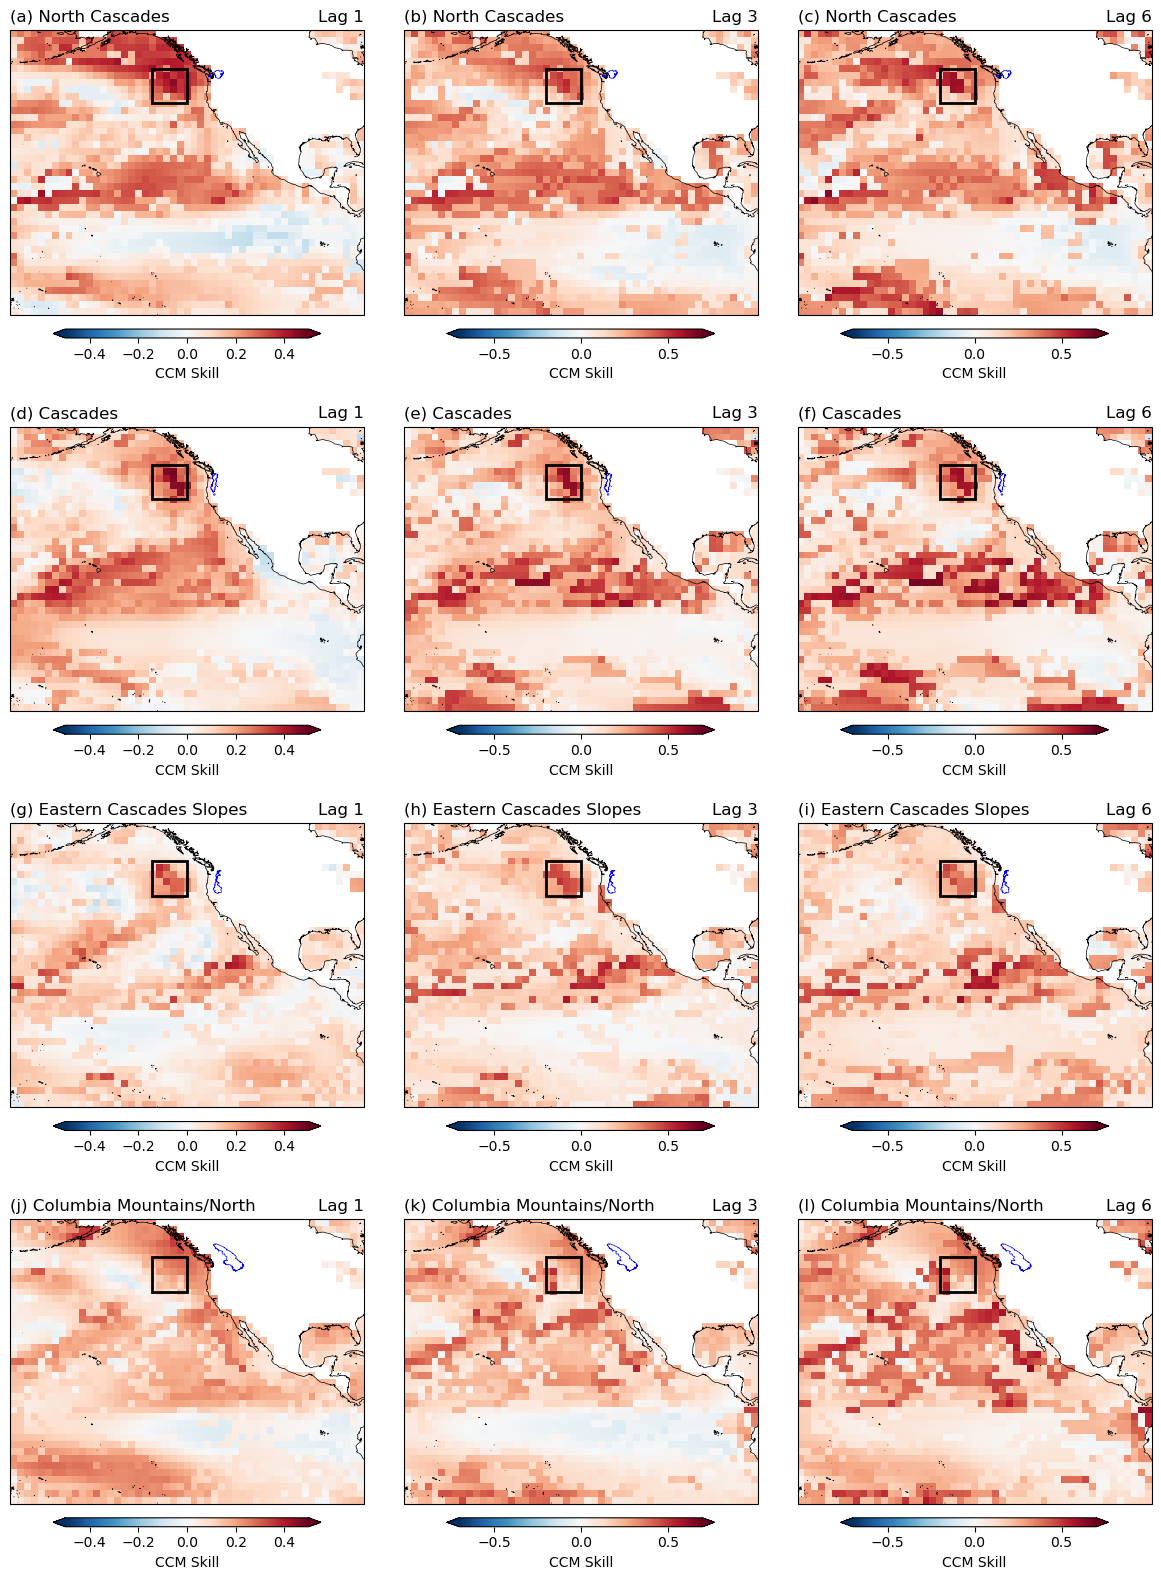

In [35]:
fig = plt.figure(figsize=(12,16))
# create gridspec
gs = fig.add_gridspec(4,3, height_ratios=[1,1,1,1],
                      width_ratios=[1,1,1])

f = ccm_results_flist[5]
lag = f.split('_')[3].split('.')[0]
ccm_xr = xr.open_dataset(f)

cbar_kwargs = {'shrink':0.7, 'aspect':30,
               'orientation':'horizontal', 'pad':0.04,
               'extend': 'both', 'label': 'CCM Skill'}

for i in range(len(coast_ecos)):
    eco_name = str(ccm_xr.sel(eco_region=coast_ecos[i]).eco_region.values)
    sub = wus_eco[wus_eco['NA_L3NAME']==eco_name]
    
    ax = fig.add_subplot(gs[i,0],
                         projection=ccrs.PlateCarree(central_longitude=180))
    ax.coastlines(resolution='50m', color='black', linewidth=0.5)
    ccm_xr.sel(eco_region=coast_ecos[i]).rho.plot(ax=ax,
                                       cmap='RdBu_r',
                                       vmin=-0.5, vmax=0.5,
                                       transform=ccrs.PlateCarree(),
                                       cbar_kwargs=cbar_kwargs)
    sub.boundary.plot(ax=ax, color='b', linewidth=0.5)
    ax.set_title('')
    ax.set_title('({}) {:.24s}'.format(alc[3*i], eco_name), loc='left', fontsize=12)
    ax.set_title('Lag {}'.format(lag), loc='right', fontsize=12)

    rect = Rectangle((220,40),10,10,
                 edgecolor='k', facecolor='None', transform=ccrs.PlateCarree(), lw=2)
    ax.add_patch(rect)
    
    # ax.set_xticks([180, 220, 260], crs=ccrs.PlateCarree())
    # ax.set_yticks([-15, 0, 15, 30, 45, 60], crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.set_ylabel('')
    ax.set_xlabel('')

f = ccm_results_flist[6]
lag = f.split('_')[3].split('.')[0]
ccm_xr = xr.open_dataset(f)

for i in range(len(coast_ecos)):
    eco_name = str(ccm_xr.sel(eco_region=coast_ecos[i]).eco_region.values)
    sub = wus_eco[wus_eco['NA_L3NAME']==eco_name]
    
    ax = fig.add_subplot(gs[i,1],
                         projection=ccrs.PlateCarree(central_longitude=180))
    ax.coastlines(resolution='50m', color='black', linewidth=0.5)
    ccm_xr.sel(eco_region=coast_ecos[i]).rho.plot(ax=ax,
                                       cmap='RdBu_r',
                                       vmin=-0.7, vmax=0.7,
                                       transform=ccrs.PlateCarree(),
                                       cbar_kwargs=cbar_kwargs)
    sub.boundary.plot(ax=ax, color='b', linewidth=0.5)
    ax.set_title('')
    ax.set_title('({}) {:.24s}'.format(alc[3*i+1], eco_name), loc='left', fontsize=12)
    ax.set_title('Lag {}'.format(lag), loc='right', fontsize=12)

    rect = Rectangle((220,40),10,10,
                 edgecolor='k', facecolor='None', transform=ccrs.PlateCarree(), lw=2)
    ax.add_patch(rect)
    
    # ax.set_xticks([180, 220, 260], crs=ccrs.PlateCarree())
    # ax.set_yticks([-15, 0, 15, 30, 45, 60], crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.set_ylabel('')
    ax.set_xlabel('')

f = ccm_results_flist[7]
lag = f.split('_')[3].split('.')[0]
ccm_xr = xr.open_dataset(f)

for i in range(len(coast_ecos)):
    eco_name = str(ccm_xr.sel(eco_region=coast_ecos[i]).eco_region.values)
    sub = wus_eco[wus_eco['NA_L3NAME']==eco_name]
    
    ax = fig.add_subplot(gs[i,2],
                         projection=ccrs.PlateCarree(central_longitude=180))
    ax.coastlines(resolution='50m', color='black', linewidth=0.5)
    ccm_xr.sel(eco_region=coast_ecos[i]).rho.plot(ax=ax,
                                       cmap='RdBu_r',
                                       vmin=-0.7, vmax=0.7,
                                       transform=ccrs.PlateCarree(),
                                       cbar_kwargs=cbar_kwargs)
    sub.boundary.plot(ax=ax, color='b', linewidth=0.5)
    ax.set_title('')
    ax.set_title('({}) {:.24s}'.format(alc[3*i+2], eco_name), loc='left', fontsize=12)
    ax.set_title('Lag {}'.format(lag), loc='right', fontsize=12)

    rect = Rectangle((220,40),10,10,
                 edgecolor='k', facecolor='None', transform=ccrs.PlateCarree(), lw=2)
    ax.add_patch(rect)

    # ax.set_xticks([180, 220, 260], crs=ccrs.PlateCarree())
    # ax.set_yticks([-15, 0, 15, 30, 45, 60], crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.set_ylabel('')
    ax.set_xlabel('')

plt.tight_layout()
plt.savefig(pub_dir+'fig2a_2l.eps',
            bbox_inches='tight',
            facecolor='w')

./data/processed/ccm_SST_tau_1.nc


In [50]:
ccm_xr

<xarray.Dataset>
Dimensions:          (eco_region: 15, lat: 41, lon: 51)
Coordinates:
  * eco_region       (eco_region) object 'Arizona/New Mexico Mountains' ... '...
  * lat              (lat) float64 -20.0 -18.0 -16.0 -14.0 ... 56.0 58.0 60.0
  * lon              (lon) float64 180.0 182.0 184.0 186.0 ... 276.0 278.0 280.0
Data variables:
    embed dims       (eco_region, lat, lon) float64 ...
    rho              (eco_region, lat, lon) float64 ...
    slope (last 20)  (eco_region, lat, lon) float64 ...
    rho reverse      (eco_region, lat, lon) float64 ...

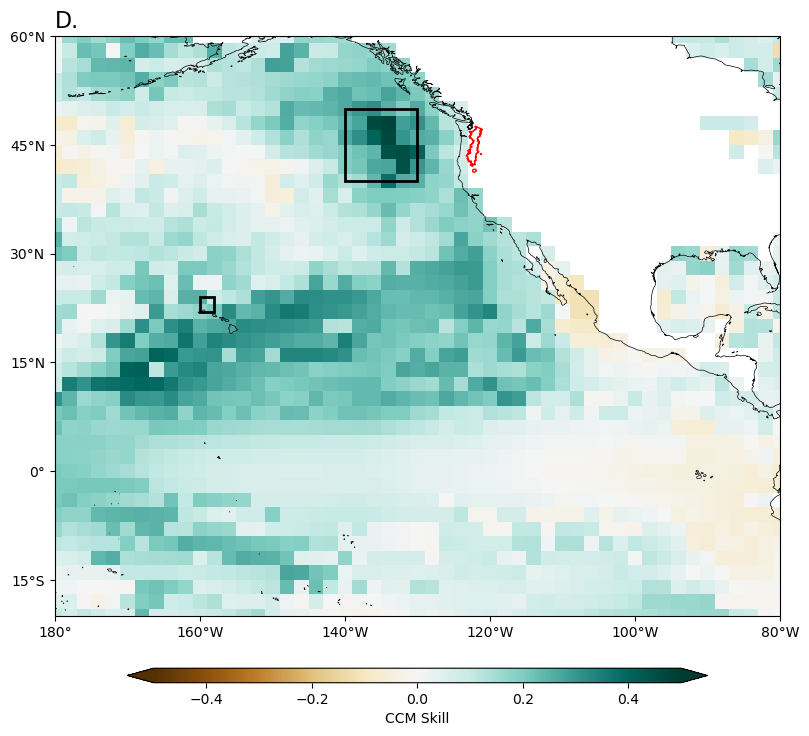

In [49]:
cbar_kwargs = {'shrink':0.8, 'aspect':40,
               'orientation':'horizontal', 'pad':0.07,
               'extend': 'both', 'label':'CCM Skill'}

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection=ccrs.PlateCarree())
ax.set_extent([-180, -80, -20, 60], crs=ccrs.PlateCarree())
# gl = ax.gridlines(draw_labels=True)
ax.coastlines(resolution='50m', color='black', linewidth=0.5)
fg = ccm_xr.sel(eco_region='Cascades').rho.plot(ax=ax,
                                   cmap='BrBG',
                                   vmin=-0.5, vmax=0.5,
                                   transform=ccrs.PlateCarree(),
                                   cbar_kwargs=cbar_kwargs)
rect1 = Rectangle((-160,22),2,2, edgecolor='k', facecolor='none', transform=ccrs.PlateCarree(), lw=2)
ax.add_patch(rect1)

sub2 = wus_eco[wus_eco['NA_L3NAME']=='Cascades']
sub2.boundary.plot(ax=ax, color='r', linewidth=1,
                   transform=ccrs.PlateCarree(central_longitude=180))
ax.set_title('')
# ax.set_title('Cascades - Lag 1', loc='left')

rect = Rectangle((220,40),10,10,
                 edgecolor='k', facecolor='None', transform=ccrs.PlateCarree(), lw=2)
ax.add_patch(rect)

ax.set_xticks([-180, -160, -140,-120,-100, -80], crs=ccrs.PlateCarree())
ax.set_yticks([-15, 0, 15, 30, 45, 60], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('D.', loc='left', fontsize=16)
plt.tight_layout()
# plt.savefig('./gsa_panel_c.svg', bbox_inches='tight', facecolor='w', dpi=300)

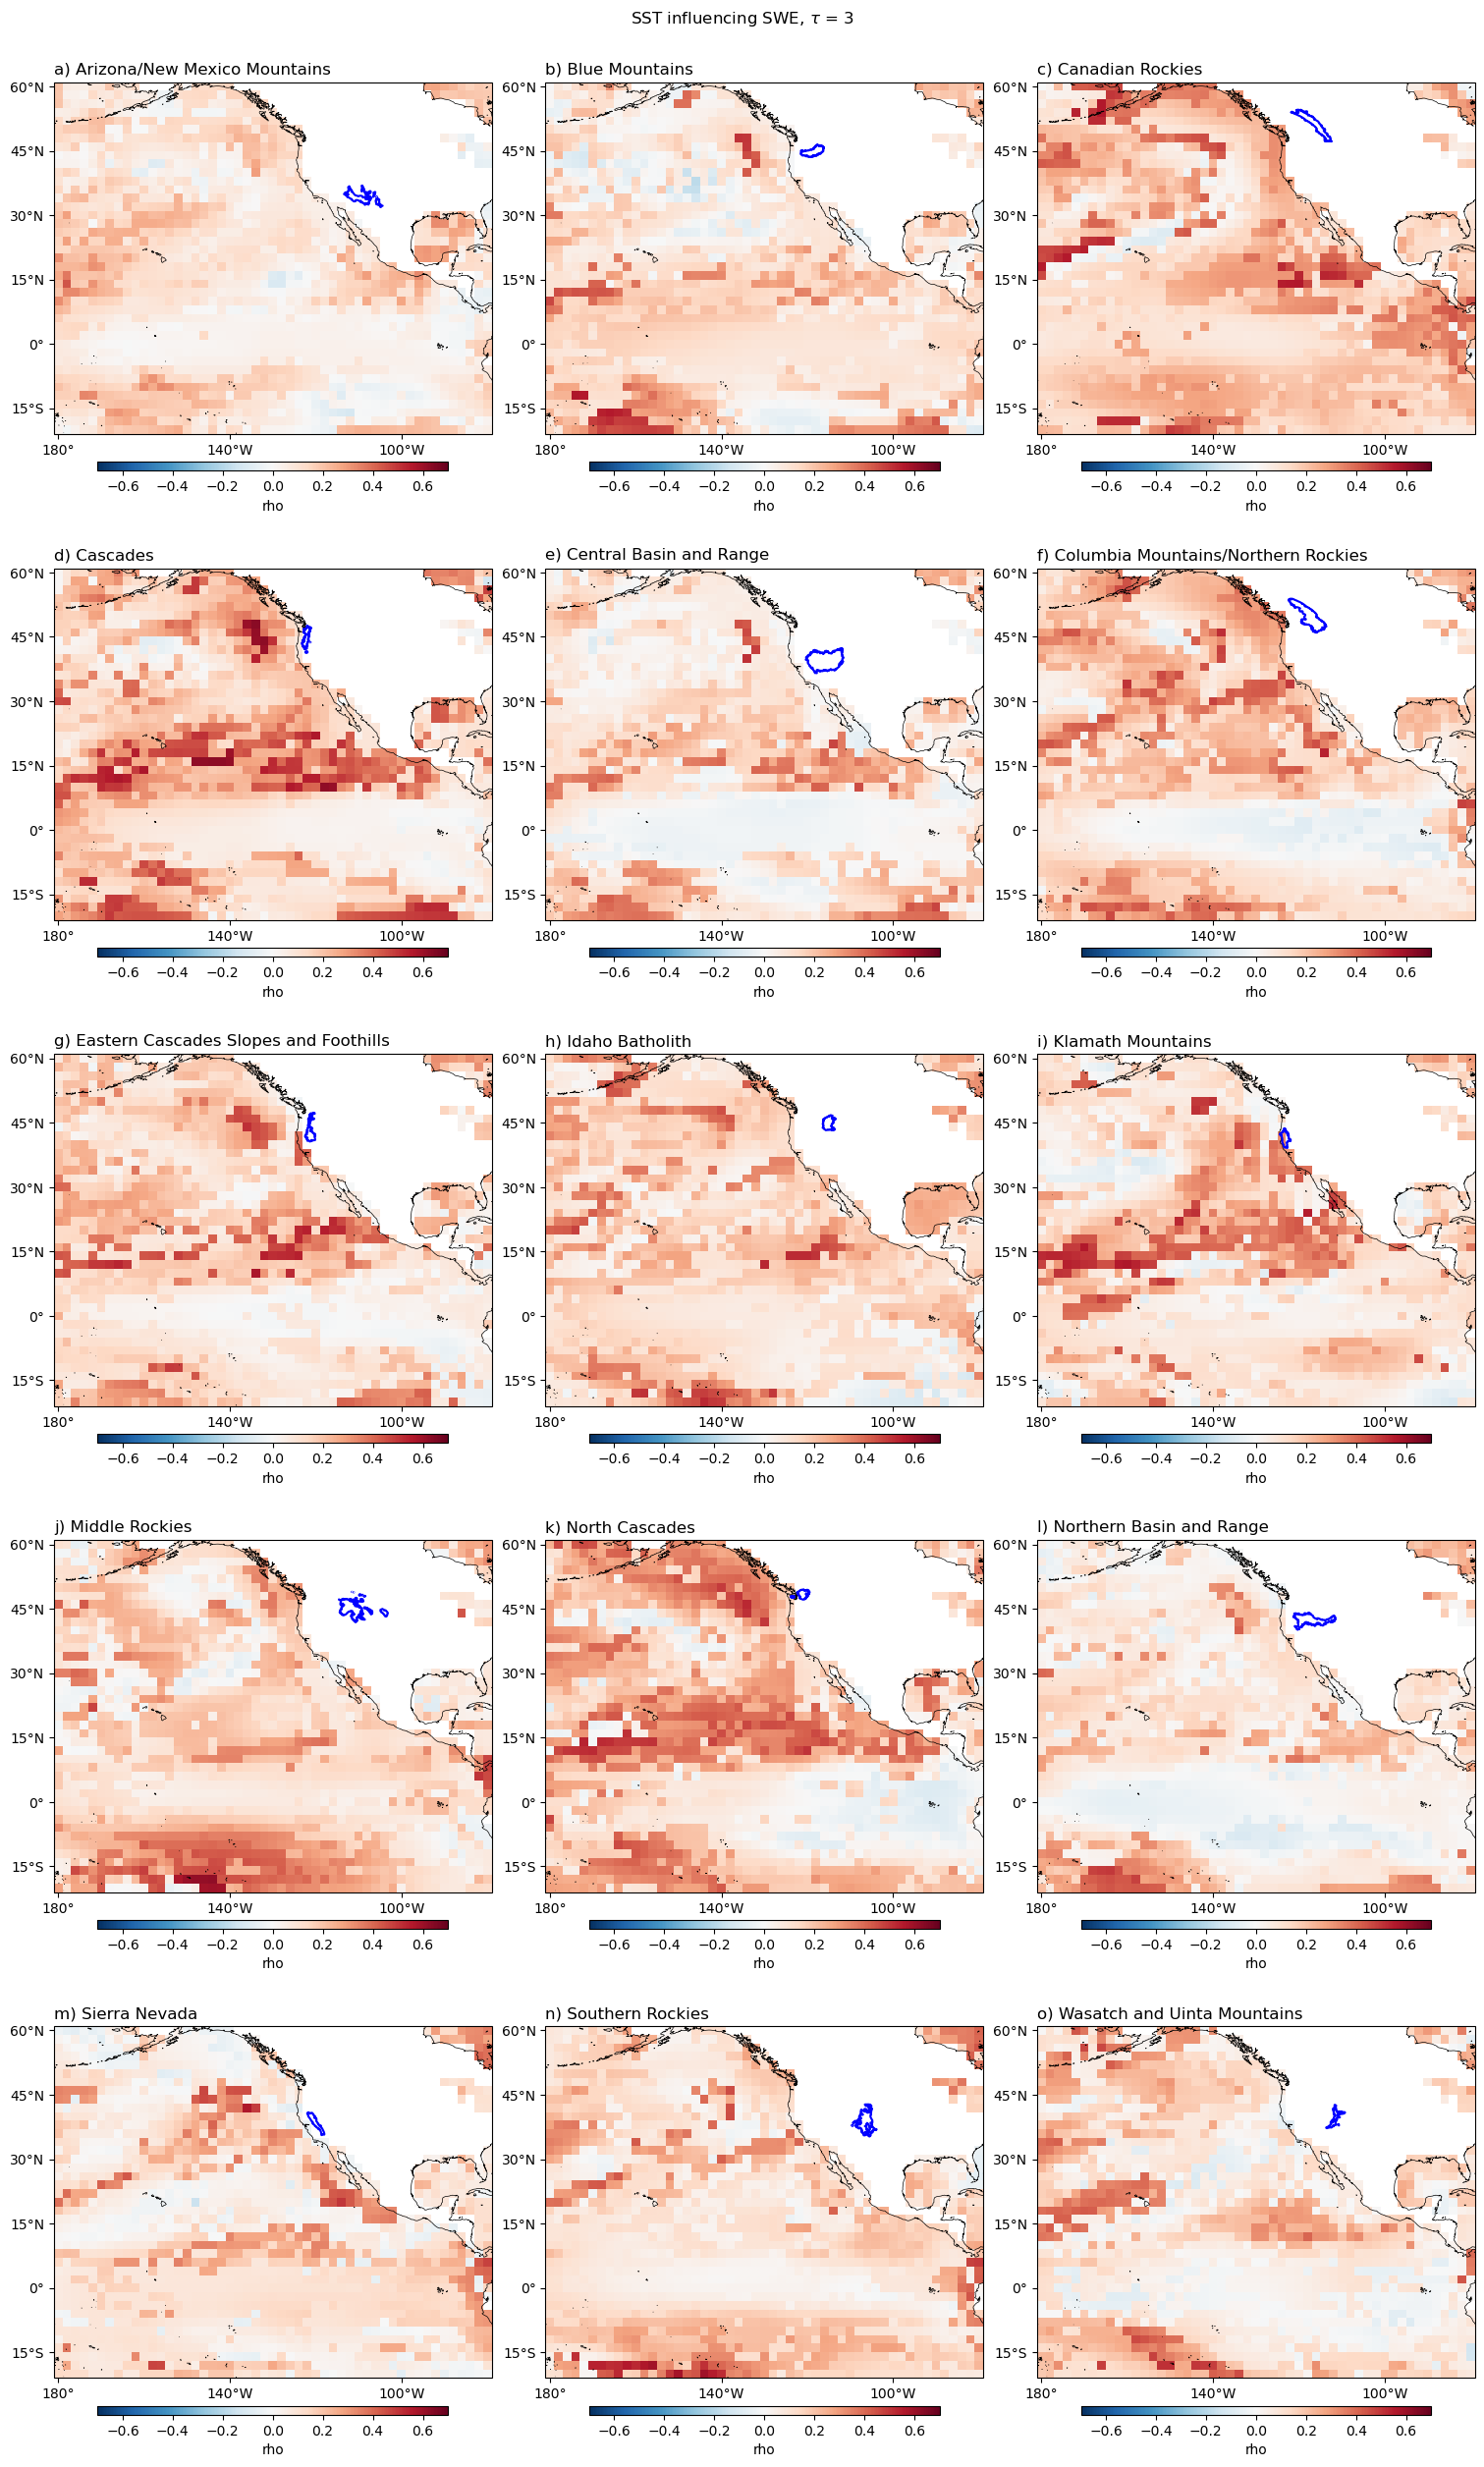

In [58]:
# def plot_ccm(f):
f = ccm_results_flist[6]

lag = f.split('_')[3].split('.')[0]
ccm_xr = xr.open_dataset(f)
fig = plt.figure(figsize=(15, 25), constrained_layout=True)
# create gridspec
gs = fig.add_gridspec(5,3, height_ratios=[1,1,1,1,1],
                      width_ratios=[1,1,1])

cbar_kwargs = {'shrink':0.8, 'aspect':40,
               'orientation':'horizontal', 'pad':0.01}

for i in range(15):
    eco_name = str(ccm_xr.isel(eco_region=i).eco_region.values)
    sub = wus_eco[wus_eco['NA_L3NAME']==eco_name]
    
    ax = fig.add_subplot(gs[i],
                         projection=ccrs.PlateCarree(central_longitude=180))
    ax.coastlines(resolution='50m', color='black', linewidth=0.5)
    ccm_xr.isel(eco_region=i).rho.plot(ax=ax,                                       
                                       cmap='RdBu_r',
                                       vmin=-0.7, vmax=0.7,
                                       transform=ccrs.PlateCarree(),
                                       cbar_kwargs=cbar_kwargs)
    sub.boundary.plot(ax=ax, color='b')
    ax.set_title('')
    ax.set_title('{}) {}'.format(alc[i], eco_name), loc='left')
    ax.set_xticks([180, 220, 260], crs=ccrs.PlateCarree())
    ax.set_yticks([-15, 0, 15, 30, 45, 60], crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.set_ylabel('')
    ax.set_xlabel('')
plt.suptitle(fr'SST influencing SWE, $\tau$ = {lag}')
plt.savefig('./figs/ccm_sst_swe_lag3.png', bbox_inches='tight', facecolor='w')
plt.show()

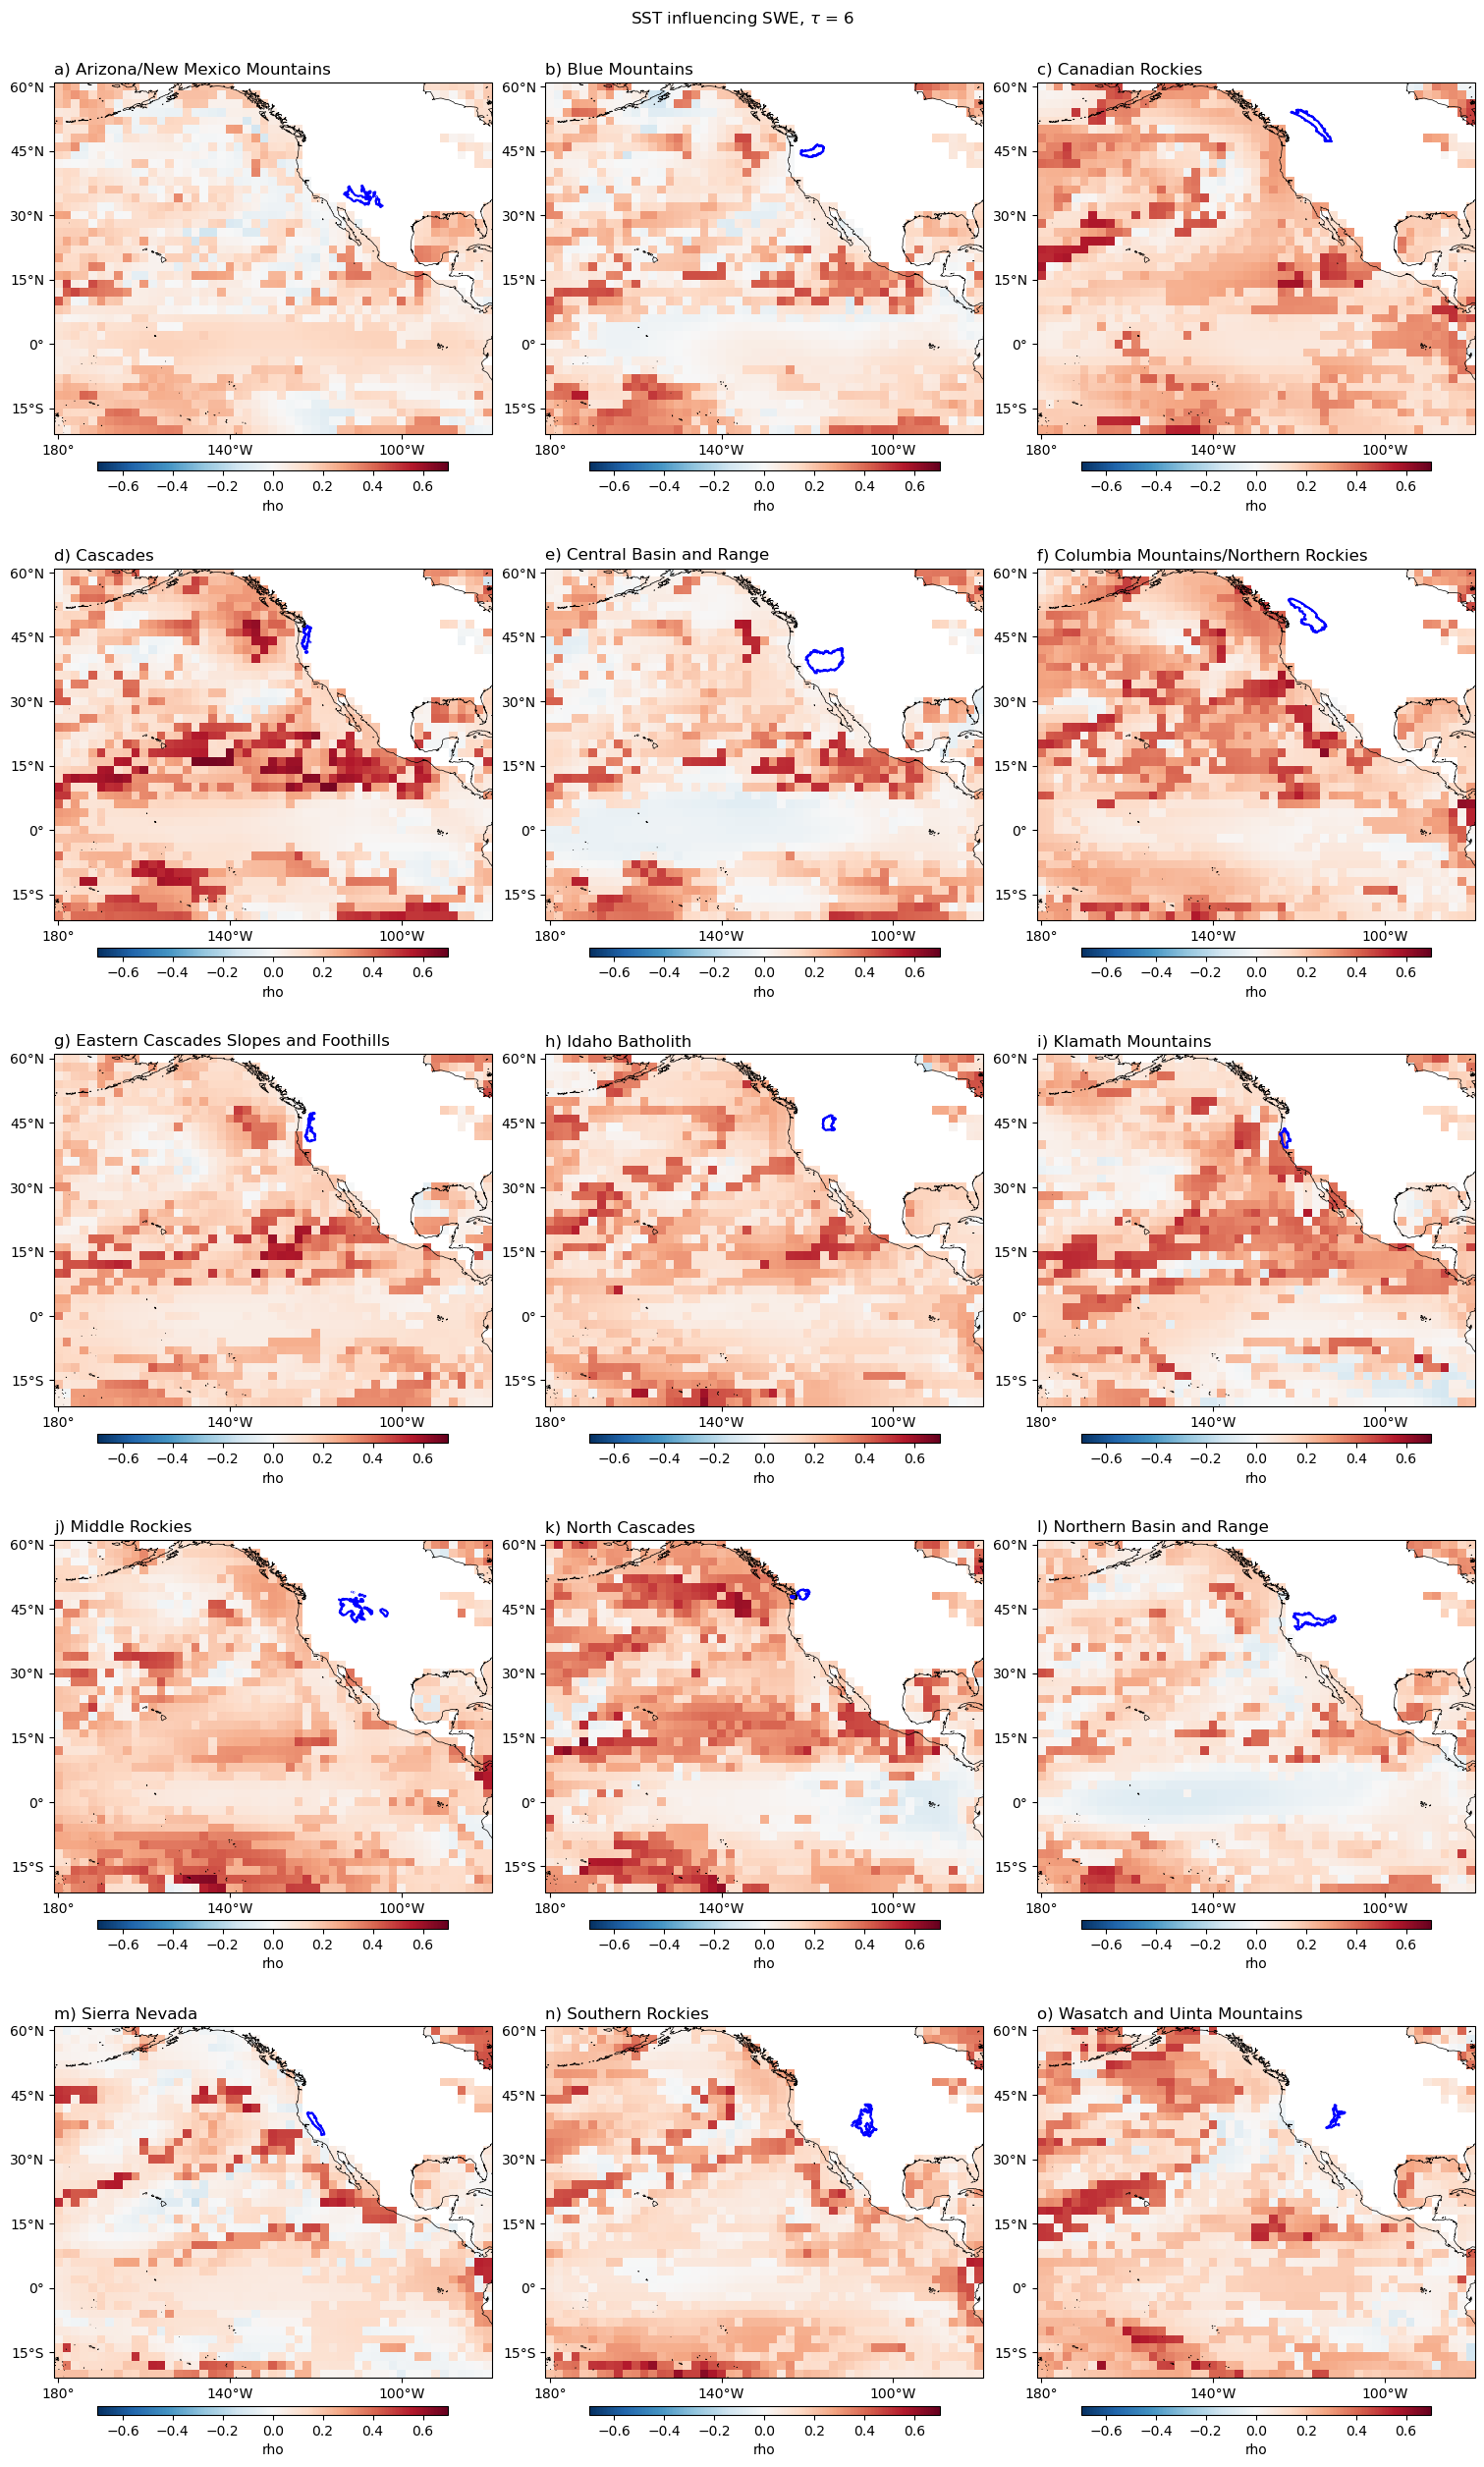

In [59]:
# def plot_ccm(f):
f = ccm_results_flist[7]

lag = f.split('_')[3].split('.')[0]
ccm_xr = xr.open_dataset(f)
fig = plt.figure(figsize=(15, 25), constrained_layout=True)
# create gridspec
gs = fig.add_gridspec(5,3, height_ratios=[1,1,1,1,1],
                      width_ratios=[1,1,1])

cbar_kwargs = {'shrink':0.8, 'aspect':40,
               'orientation':'horizontal', 'pad':0.01}

for i in range(15):
    eco_name = str(ccm_xr.isel(eco_region=i).eco_region.values)
    sub = wus_eco[wus_eco['NA_L3NAME']==eco_name]
    
    ax = fig.add_subplot(gs[i],
                         projection=ccrs.PlateCarree(central_longitude=180))
    ax.coastlines(resolution='50m', color='black', linewidth=0.5)
    ccm_xr.isel(eco_region=i).rho.plot(ax=ax,
                                       cmap='RdBu_r',
                                       vmin=-0.7, vmax=0.7,
                                       transform=ccrs.PlateCarree(),
                                       cbar_kwargs=cbar_kwargs)
    sub.boundary.plot(ax=ax, color='b')
    ax.set_title('')
    ax.set_title('{}) {}'.format(alc[i], eco_name), loc='left')

    ax.set_xticks([180, 220, 260], crs=ccrs.PlateCarree())
    ax.set_yticks([-15, 0, 15, 30, 45, 60], crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.set_ylabel('')
    ax.set_xlabel('')
plt.suptitle(fr'SST influencing SWE, $\tau$ = {lag}')
plt.savefig('./figs/ccm_sst_swe_lag6.png', bbox_inches='tight', facecolor='w')
plt.show()

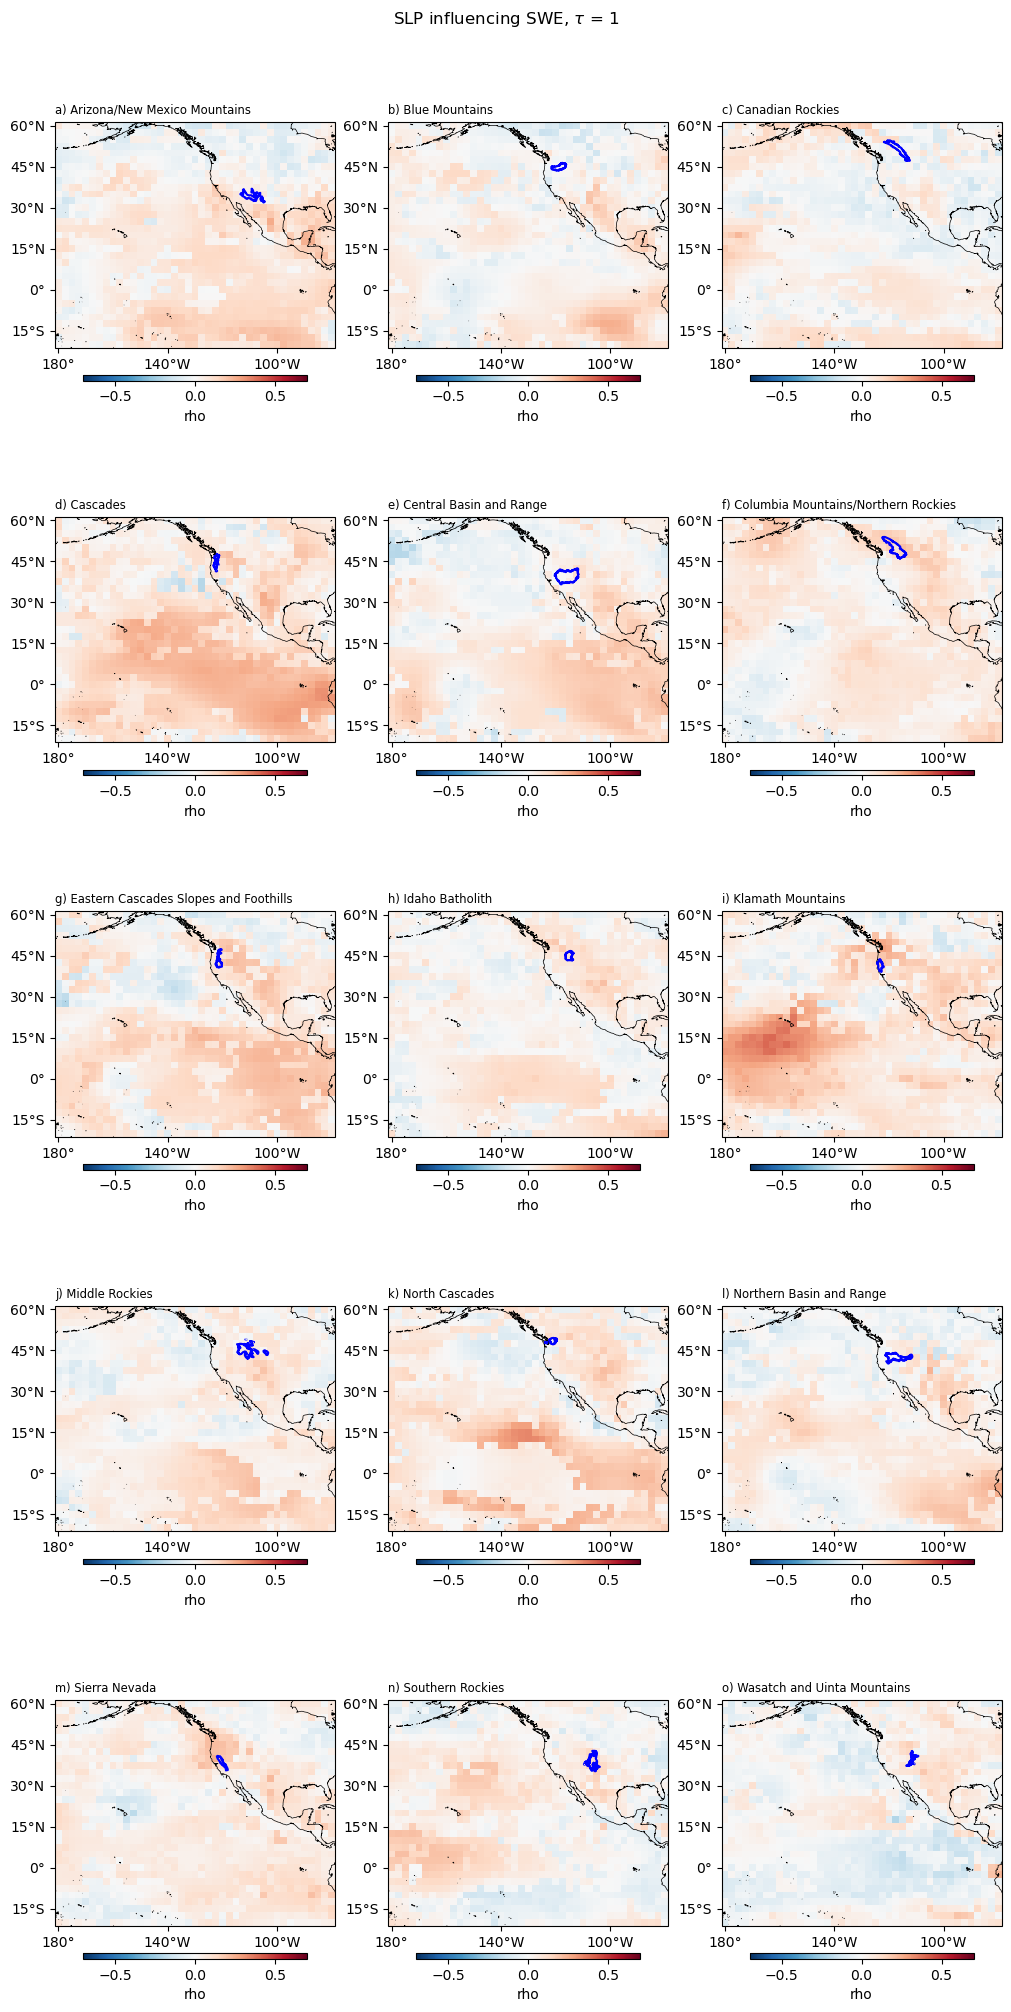

In [13]:
# def plot_ccm(f):
f = ccm_results_flist[0]

lag = f.split('_')[3].split('.')[0]
ccm_xr = xr.open_dataset(f)
fig = plt.figure(figsize=(10, 20), constrained_layout=True)
# create gridspec
gs = fig.add_gridspec(5,3, height_ratios=[1,1,1,1,1],
                      width_ratios=[1,1,1])

cbar_kwargs = {'shrink':0.8, 'aspect':40,
               'orientation':'horizontal', 'pad':0.01}

for i in range(15):
    eco_name = str(ccm_xr.isel(eco_region=i).eco_region.values)
    sub = wus_eco[wus_eco['NA_L3NAME']==eco_name]
    
    ax = fig.add_subplot(gs[i],
                         projection=ccrs.PlateCarree(central_longitude=180))
    ax.coastlines(resolution='50m', color='black', linewidth=0.5)
    ccm_xr.isel(eco_region=i).rho.plot(ax=ax,                                       
                                       cmap='RdBu_r',
                                       vmin=-0.7, vmax=0.7,
                                       transform=ccrs.PlateCarree(),
                                       cbar_kwargs=cbar_kwargs)
    sub.boundary.plot(ax=ax, color='b')
    ax.set_title('')
    ax.set_title('{}) {}'.format(alc[i], eco_name), loc='left', fontsize='small')

    ax.set_xticks([180, 220, 260], crs=ccrs.PlateCarree())
    ax.set_yticks([-15, 0, 15, 30, 45, 60], crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.set_ylabel('')
    ax.set_xlabel('')
plt.suptitle(fr'SLP influencing SWE, $\tau$ = {lag}')
# plt.savefig('./figs/ccm_slp_swe_lag1.png', bbox_inches='tight', facecolor='w')
plt.show()

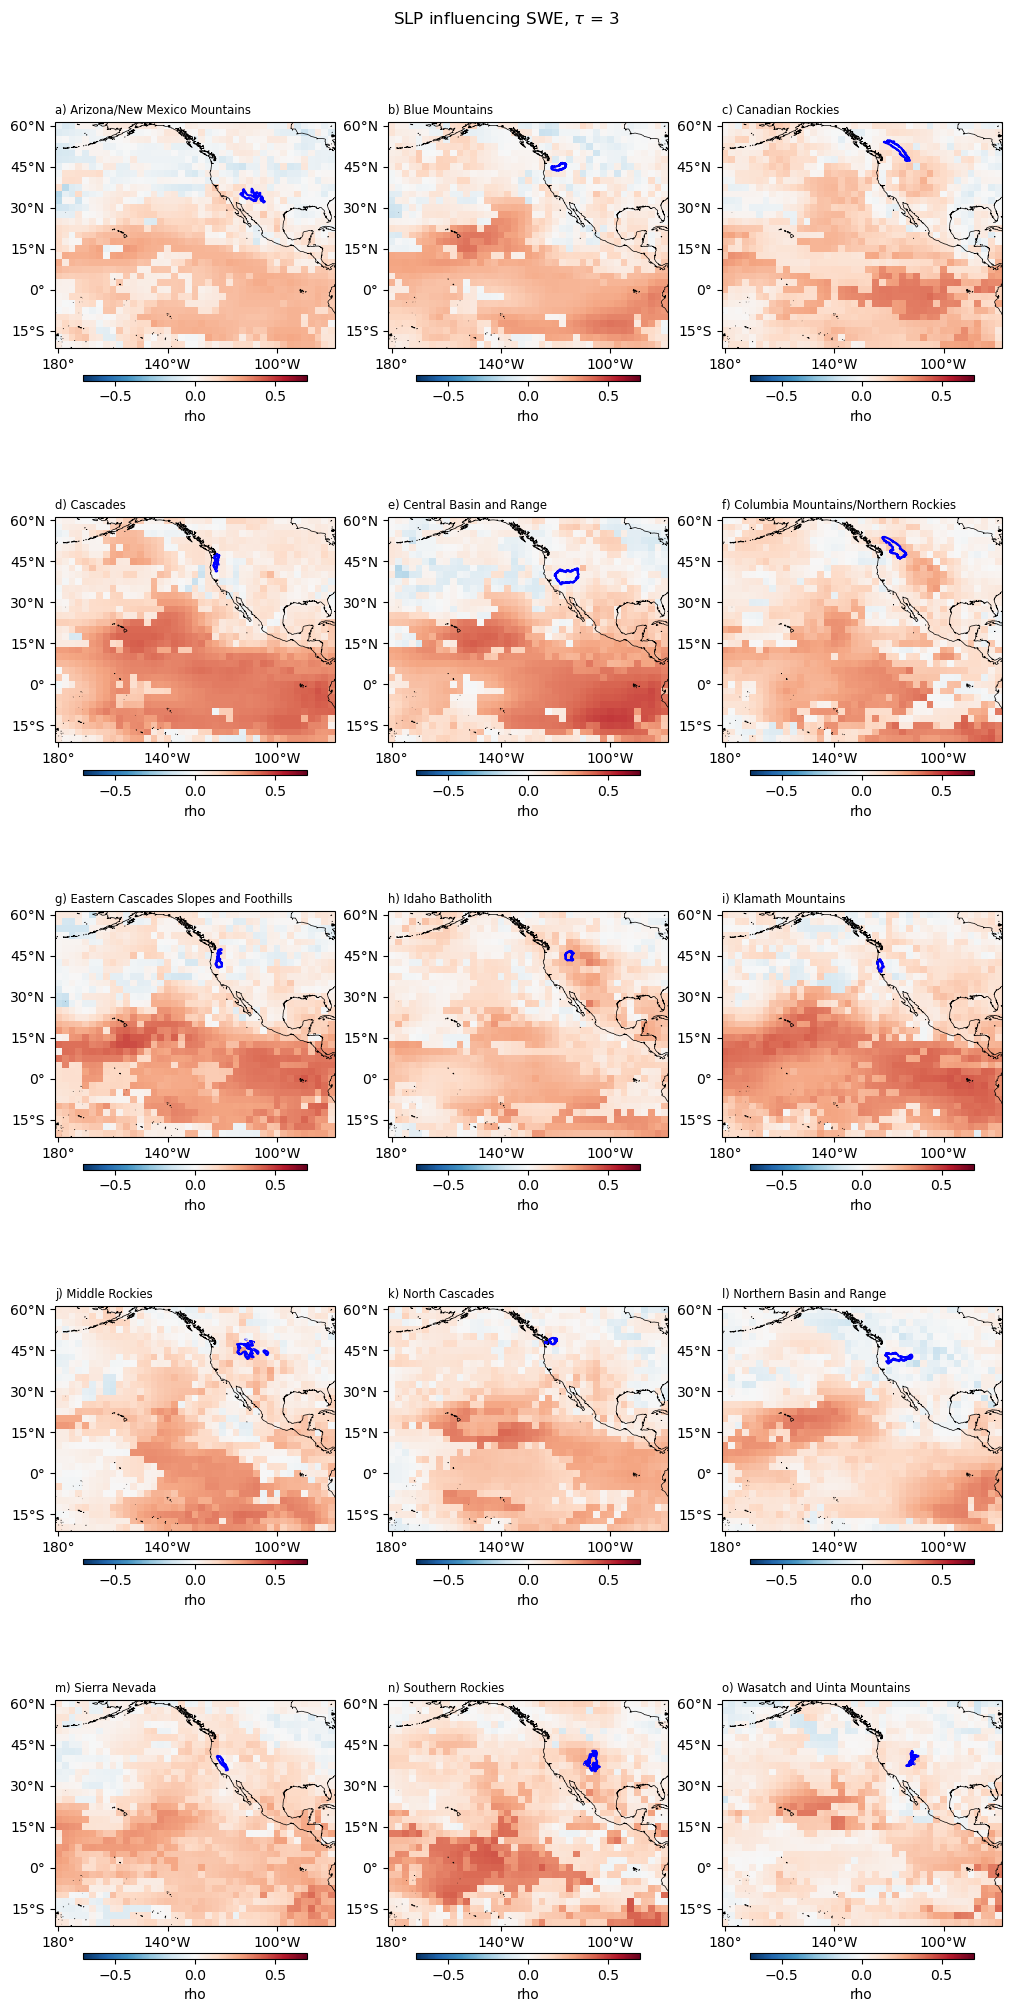

In [14]:
# def plot_ccm(f):
f = ccm_results_flist[1]

lag = f.split('_')[3].split('.')[0]
ccm_xr = xr.open_dataset(f)
fig = plt.figure(figsize=(10, 20), constrained_layout=True)
# create gridspec
gs = fig.add_gridspec(5,3, height_ratios=[1,1,1,1,1],
                      width_ratios=[1,1,1])

cbar_kwargs = {'shrink':0.8, 'aspect':40,
               'orientation':'horizontal', 'pad':0.01}

for i in range(15):
    eco_name = str(ccm_xr.isel(eco_region=i).eco_region.values)
    sub = wus_eco[wus_eco['NA_L3NAME']==eco_name]
    
    ax = fig.add_subplot(gs[i],
                         projection=ccrs.PlateCarree(central_longitude=180))
    ax.coastlines(resolution='50m', color='black', linewidth=0.5)
    ccm_xr.isel(eco_region=i).rho.plot(ax=ax,                                       
                                       cmap='RdBu_r',
                                       vmin=-0.7, vmax=0.7,
                                       transform=ccrs.PlateCarree(),
                                       cbar_kwargs=cbar_kwargs)
    sub.boundary.plot(ax=ax, color='b')
    ax.set_title('')
    ax.set_title('{}) {}'.format(alc[i], eco_name), loc='left', fontsize='small')

    ax.set_xticks([180, 220, 260], crs=ccrs.PlateCarree())
    ax.set_yticks([-15, 0, 15, 30, 45, 60], crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.set_ylabel('')
    ax.set_xlabel('')
plt.suptitle(fr'SLP influencing SWE, $\tau$ = {lag}')
# plt.savefig('./figs/ccm_slp_swe_lag3.png', bbox_inches='tight', facecolor='w')
plt.show()

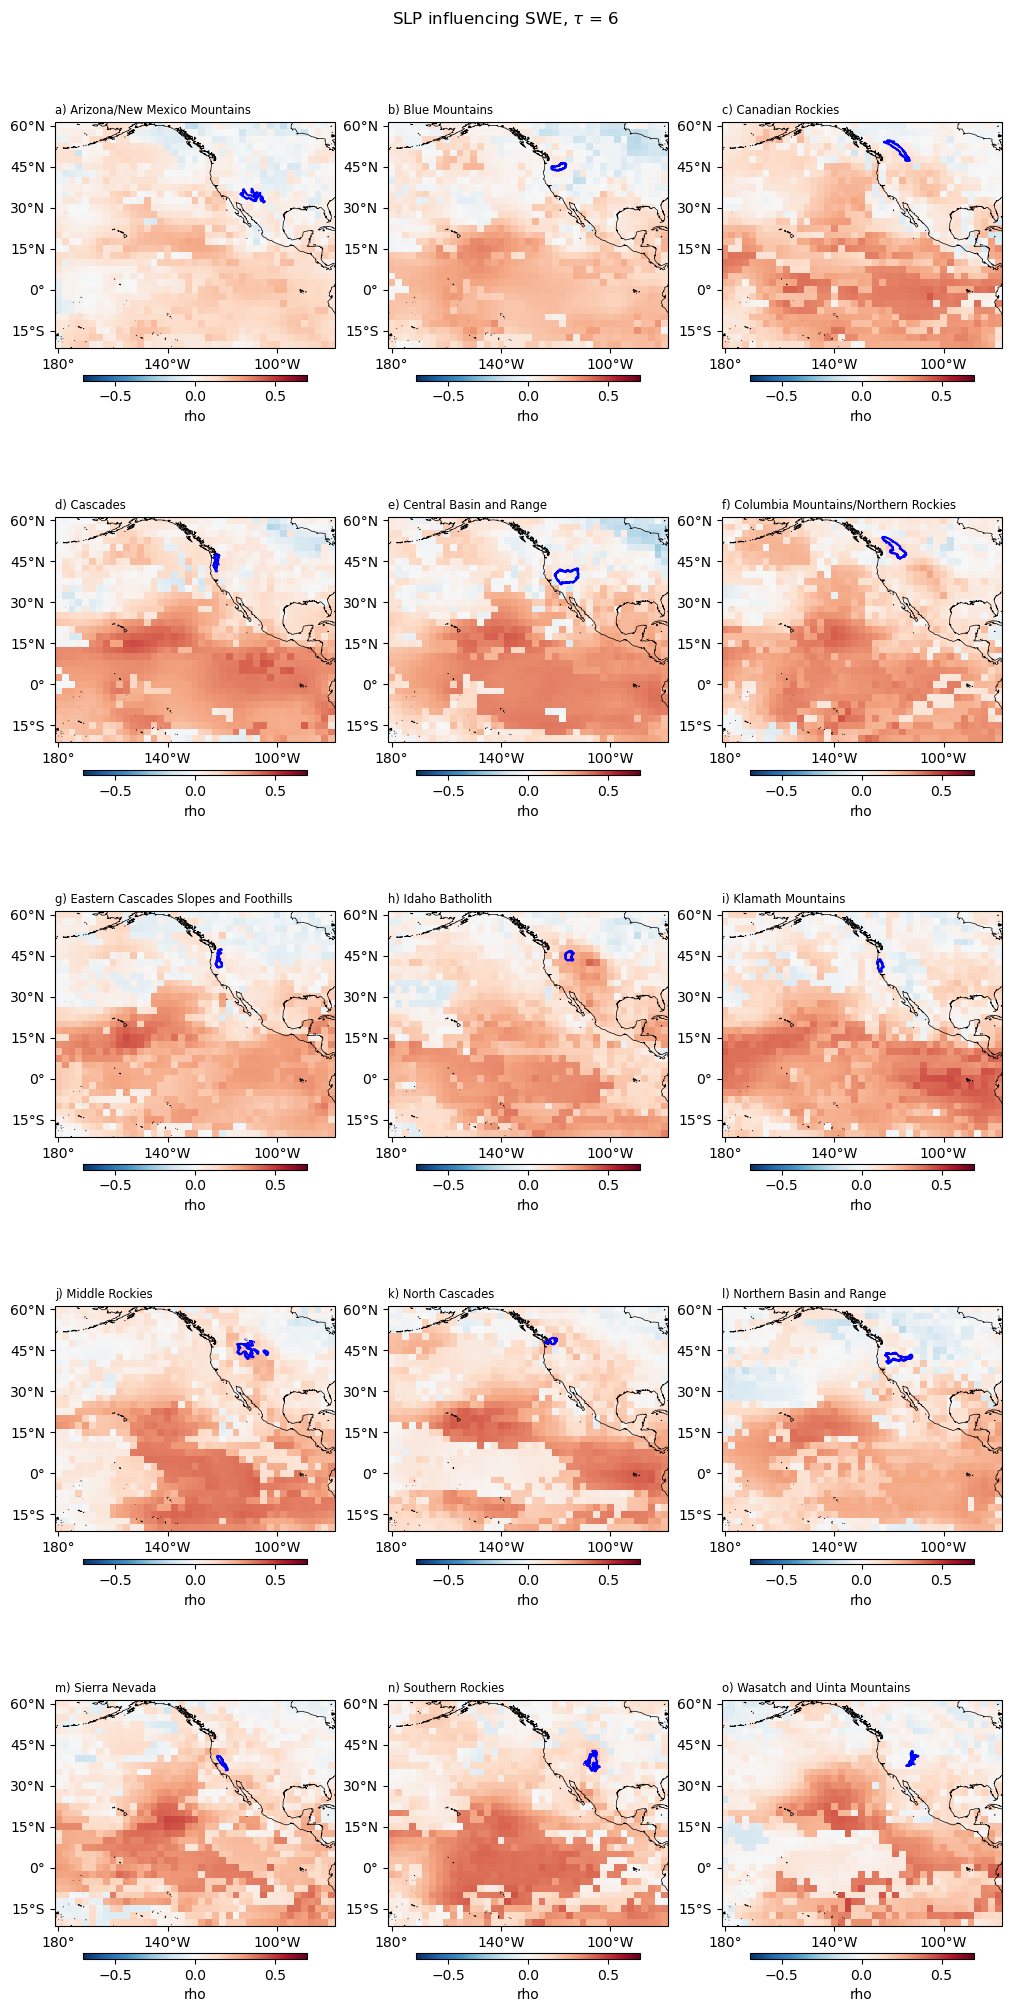

In [15]:
# def plot_ccm(f):
f = ccm_results_flist[2]

lag = f.split('_')[3].split('.')[0]
ccm_xr = xr.open_dataset(f)
fig = plt.figure(figsize=(10, 20), constrained_layout=True)
# create gridspec
gs = fig.add_gridspec(5,3, height_ratios=[1,1,1,1,1],
                      width_ratios=[1,1,1])

cbar_kwargs = {'shrink':0.8, 'aspect':40,
               'orientation':'horizontal', 'pad':0.01}

for i in range(15):
    eco_name = str(ccm_xr.isel(eco_region=i).eco_region.values)
    sub = wus_eco[wus_eco['NA_L3NAME']==eco_name]
    
    ax = fig.add_subplot(gs[i],
                         projection=ccrs.PlateCarree(central_longitude=180))
    ax.coastlines(resolution='50m', color='black', linewidth=0.5)
    ccm_xr.isel(eco_region=i).rho.plot(ax=ax,                                       
                                       cmap='RdBu_r',
                                       vmin=-0.7, vmax=0.7,
                                       transform=ccrs.PlateCarree(),
                                       cbar_kwargs=cbar_kwargs)
    sub.boundary.plot(ax=ax, color='b')
    ax.set_title('')
    ax.set_title('{}) {}'.format(alc[i], eco_name), loc='left', fontsize='small')

    ax.set_xticks([180, 220, 260], crs=ccrs.PlateCarree())
    ax.set_yticks([-15, 0, 15, 30, 45, 60], crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.set_ylabel('')
    ax.set_xlabel('')
plt.suptitle(fr'SLP influencing SWE, $\tau$ = {lag}')
# plt.savefig('./figs/ccm_slp_swe_lag6.png', bbox_inches='tight', facecolor='w')
plt.show()

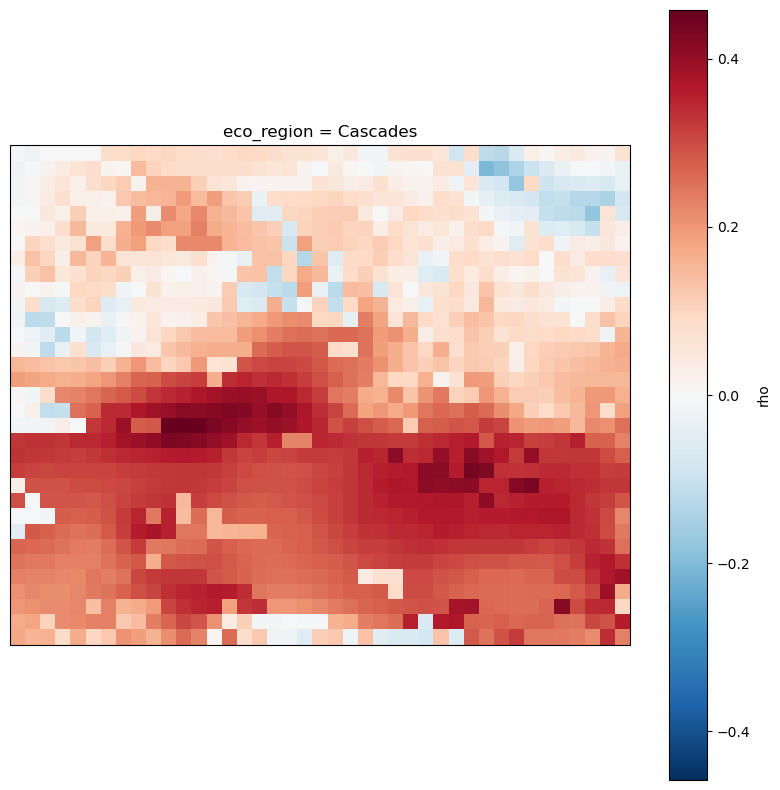

In [16]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
# ax.coastlines(resolution='50m', color='black', linewidth=1)

# ax.set_extent([0, 360, -60, 60], crs=ccrs.PlateCarree())
ccm_xr.isel(eco_region=3).rho.plot(ax=ax, transform=ccrs.PlateCarree())

In [17]:
ccm_xr.isel(eco_region=0)

<xarray.Dataset>
Dimensions:     (lat: 33, lon: 41)
Coordinates:
    eco_region  <U28 'Arizona/New Mexico Mountains'
  * lat         (lat) float64 -20.0 -17.5 -15.0 -12.5 ... 52.5 55.0 57.5 60.0
  * lon         (lon) float64 180.0 182.5 185.0 187.5 ... 275.0 277.5 280.0
Data variables:
    rho         (lat, lon) float64 ...

In [18]:
str(ccm_xr.isel(eco_region=0).eco_region.values)

'Arizona/New Mexico Mountains'

In [19]:
wus_eco

NA_L3CODE                              NA_L3NAME NA_L2CODE  \
61      10.1.3               Northern Basin and Range      10.1   
63      10.1.5                Central Basin and Range      10.1   
142     13.1.1           Arizona/New Mexico Mountains      13.1   
143     13.1.1           Arizona/New Mexico Mountains      13.1   
144     13.1.1           Arizona/New Mexico Mountains      13.1   
145     13.1.1           Arizona/New Mexico Mountains      13.1   
146     13.1.1           Arizona/New Mexico Mountains      13.1   
147     13.1.1           Arizona/New Mexico Mountains      13.1   
148     13.1.1           Arizona/New Mexico Mountains      13.1   
149     13.1.1           Arizona/New Mexico Mountains      13.1   
150     13.1.1           Arizona/New Mexico Mountains      13.1   
151     13.1.1           Arizona/New Mexico Mountains      13.1   
1113    6.2.10                         Middle Rockies       6.2   
1114    6.2.10                         Middle Rockies       6.2   
1115    6.2.10                         Middle Rockies       6.2   
1116    6.2.10                         Middle Rockies       6.2   
1117    6.2.10                         Middle Rockies       6.2   
1118    6.2.10                         Middle Rockies       6.2   
1119    6.2.10                         Middle Rockies       6.2   
1120    6.2.10                         Middle Rockies       6.2   
1121    6.2.10                         Middle Rockies       6.2   
1122    6.2.10                         Middle Rockies       6.2   
1123    6.2.10                         Middle Rockies       6.2   
1124    6.2.10                         Middle Rockies       6.2   
1125    6.2.10                         Middle Rockies       6.2   
1126    6.2.10                         Middle Rockies       6.2   
1127    6.2.10                         Middle Rockies       6.2   
1128    6.2.10                         Middle Rockies       6.2   
1129    6.2.10                         Middle Rockies       6.2   
1130    6.2.11                      Klamath Mountains       6.2   
1131    6.2.12                          Sierra Nevada       6.2   
1132    6.2.13            Wasatch and Uinta Mountains       6.2   
1133    6.2.13            Wasatch and Uinta Mountains       6.2   
1134    6.2.13            Wasatch and Uinta Mountains       6.2   
1135    6.2.14                       Southern Rockies       6.2   
1136    6.2.14                       Southern Rockies       6.2   
1137    6.2.14                       Southern Rockies       6.2   
1138    6.2.14                       Southern Rockies       6.2   
1139    6.2.15                        Idaho Batholith       6.2   
1141     6.2.3    Columbia Mountains/Northern Rockies       6.2   
1142     6.2.4                       Canadian Rockies       6.2   
1143     6.2.5                         North Cascades       6.2   
1144     6.2.5                         North Cascades       6.2   
1145     6.2.5                         North Cascades       6.2   
1147     6.2.9                         Blue Mountains       6.2   
2541     6.2.7                               Cascades       6.2   
2542     6.2.7                               Cascades       6.2   
2543     6.2.7                               Cascades       6.2   
2544     6.2.7                               Cascades       6.2   
2545     6.2.8  Eastern Cascades Slopes and Foothills       6.2   

                 NA_L2NAME NA_L1CODE                        NA_L1NAME  \
61            COLD DESERTS        10           NORTH AMERICAN DESERTS   
63            COLD DESERTS        10           NORTH AMERICAN DESERTS   
142   UPPER GILA MOUNTAINS        13                TEMPERATE SIERRAS   
143   UPPER GILA MOUNTAINS        13                TEMPERATE SIERRAS   
144   UPPER GILA MOUNTAINS        13                TEMPERATE SIERRAS   
145   UPPER GILA MOUNTAINS        13                TEMPERATE SIERRAS   
146   UPPER GILA MOUNTAINS        13                TEMPERATE SIERRAS   
147

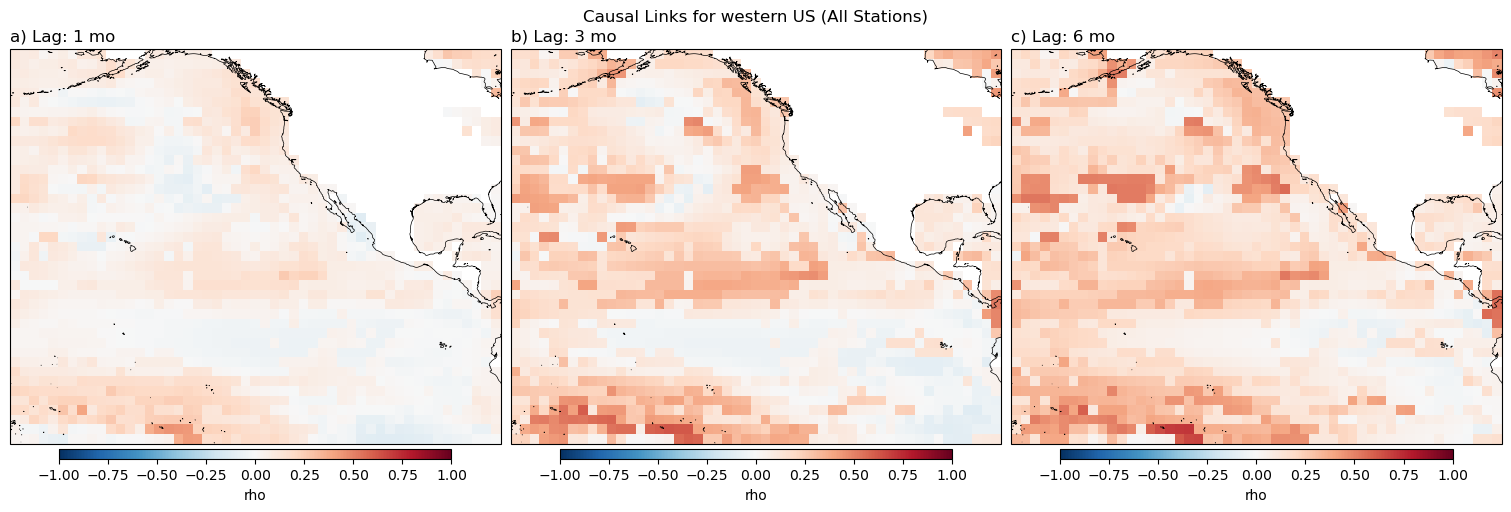

In [27]:
wus_ccm_sst_xr_lag1 = xr.open_dataset('../data/processed/ccm_wus_SST_tau_1.nc')
wus_ccm_sst_xr_lag3 = xr.open_dataset('../data/processed/ccm_wus_SST_tau_3.nc')
wus_ccm_sst_xr_lag6 = xr.open_dataset('../data/processed/ccm_wus_SST_tau_6.nc')

fig = plt.figure(figsize=(15, 5), constrained_layout=True)
# create gridspec
gs = fig.add_gridspec(1,3,
                      width_ratios=[1,1,1])

ax1 = fig.add_subplot(gs[0],
                     projection=ccrs.PlateCarree(central_longitude=180))
ax1.coastlines(resolution='50m', color='black', linewidth=0.5)
wus_ccm_sst_xr_lag1.rho.plot(ax=ax1,                                       
                             cmap='RdBu_r',
                             vmin=-1, vmax=1,
                             transform=ccrs.PlateCarree(),
                             cbar_kwargs=cbar_kwargs)
ax1.set_title('')
ax1.set_title('a) Lag: 1 mo', loc='left')

ax2 = fig.add_subplot(gs[1],
                     projection=ccrs.PlateCarree(central_longitude=180))
ax2.coastlines(resolution='50m', color='black', linewidth=0.5)
wus_ccm_sst_xr_lag3.rho.plot(ax=ax2,                                       
                             cmap='RdBu_r',
                             vmin=-1, vmax=1,
                             transform=ccrs.PlateCarree(),
                             cbar_kwargs=cbar_kwargs)
ax2.set_title('')
ax2.set_title('b) Lag: 3 mo', loc='left')

ax3 = fig.add_subplot(gs[2],
                     projection=ccrs.PlateCarree(central_longitude=180))
ax3.coastlines(resolution='50m', color='black', linewidth=0.5)
wus_ccm_sst_xr_lag6.rho.plot(ax=ax3,                                       
                             cmap='RdBu_r',
                             vmin=-1.0, vmax=1.0,
                             transform=ccrs.PlateCarree(),
                             cbar_kwargs=cbar_kwargs)
ax3.set_title('')
ax3.set_title('c) Lag: 6 mo', loc='left')
plt.suptitle('Causal Links for western US (All Stations)')
plt.show()

In [ ]:
wus_ccm_sst_xr_lag1

## test against correlation

In [44]:
sst_anoms = xr.open_dataset('./data/SST_anoms.nc')

In [45]:
swe_anoms_flist = np.sort(glob.glob('./data/snow_by_eco/*.nc'))

In [46]:
for f in swe_anoms_flist:
    swe_anoms = xr.open_dataset(f)
    corr_mat = np.zeros([41,51])
    pval_mat = np.zeros([41,51])
    start = swe_anoms.mean(dim='sites').dropna(dim='time').time[0].dt.date.values
    end = swe_anoms.mean(dim='sites').dropna(dim='time').time[-1].dt.date.values
    swe_ts = swe_anoms.mean(dim='sites').dropna(dim='time').swe_level2.to_dataframe()
    eco = swe_anoms.swe_level2.attrs['eco_region'].replace('/','_').replace(' ','_')
    
    for i in range(41):
        for j in range(51):
            sst_ts_1 = sst_anoms.sel(time=slice(start,end)).isel(lon=j, lat=i).sst.to_dataframe()
            if sst_ts_1.isnull().any().any():
                corr_mat[i,j] = np.nan
                pval_mat[i,j] = np.nan
            else:
                ts = sst_ts_1.join(swe_ts, how='inner')

                ssts = ts['sst'].to_numpy()
                swes = ts['swe_level2'].to_numpy()

                r_lag6, p_lag6 = stats.pearsonr(ssts[0:-6], swes[6:])
                corr_mat[i,j] = np.round(r_lag6,3)
                pval_mat[i,j] = np.round(p_lag6,4)
    np.savetxt('./data/corr/lag6/corrs_{}_lag6.csv'.format(eco), corr_mat,  delimiter = ",")
    np.savetxt('./data/corr/lag6/pvals_{}_lag6.csv'.format(eco), pval_mat,  delimiter = ",")

FileNotFoundError: [Errno 2] No such file or directory: './data/corr/lag6/corrs_Arizona_New_Mexico_Mountains_lag6.csv'

In [47]:
eco_sorted = np.sort(eco_regions)

In [48]:
corr_files = np.sort(glob.glob('./data/corr/lag1/corr*.csv'))
pval_files = np.sort(glob.glob('./data/corr/lag1/p*.csv'))

lag1_c = np.zeros([41,51,15])
lag1_p = np.zeros([41,51,15])

for i in range(15):
    cmat = np.genfromtxt(corr_files[i], delimiter=',', usemask=False)
    pmat = np.genfromtxt(pval_files[i], delimiter=',', usemask=False)
    lag1_c[:,:,i] = cmat
    lag1_p[:,:,i] = pmat

IndexError: index 0 is out of bounds for axis 0 with size 0

In [125]:
corr_files = np.sort(glob.glob('./data/corr/lag3/corr*.csv'))
pval_files = np.sort(glob.glob('./data/corr/lag3/p*.csv'))

lag3_c = np.zeros([41,51,15])
lag3_p = np.zeros([41,51,15])

for i in range(15):
    cmat = np.genfromtxt(corr_files[i], delimiter=',', usemask=False)
    pmat = np.genfromtxt(pval_files[i], delimiter=',', usemask=False)
    lag3_c[:,:,i] = cmat
    lag3_p[:,:,i] = pmat

In [126]:
corr_files = np.sort(glob.glob('./data/corr/lag6/corr*.csv'))
pval_files = np.sort(glob.glob('./data/corr/lag6/p*.csv'))

lag6_c = np.zeros([41,51,15])
lag6_p = np.zeros([41,51,15])

for i in range(15):
    cmat = np.genfromtxt(corr_files[i], delimiter=',', usemask=False)
    pmat = np.genfromtxt(pval_files[i], delimiter=',', usemask=False)
    lag6_c[:,:,i] = cmat
    lag6_p[:,:,i] = pmat

In [88]:
lons = sst_anoms.lon.values

In [89]:
lons

array([180., 182., 184., 186., 188., 190., 192., 194., 196., 198., 200.,
       202., 204., 206., 208., 210., 212., 214., 216., 218., 220., 222.,
       224., 226., 228., 230., 232., 234., 236., 238., 240., 242., 244.,
       246., 248., 250., 252., 254., 256., 258., 260., 262., 264., 266.,
       268., 270., 272., 274., 276., 278., 280.], dtype=float32)

In [90]:
lats = sst_anoms.lat.values

In [92]:
lats

array([ 60.,  58.,  56.,  54.,  52.,  50.,  48.,  46.,  44.,  42.,  40.,
        38.,  36.,  34.,  32.,  30.,  28.,  26.,  24.,  22.,  20.,  18.,
        16.,  14.,  12.,  10.,   8.,   6.,   4.,   2.,   0.,  -2.,  -4.,
        -6.,  -8., -10., -12., -14., -16., -18., -20.], dtype=float32)

In [41]:
lag1_ds = xr.Dataset(
    data_vars=dict(
        corr=(['lat', 'lon', 'eco'], lag1_c),
        pval=(['lat', 'lon', 'eco'], lag1_p)
    ),
    coords = dict(
        lat=lats,
        lon=lons,
        eco=eco_sorted
    ),
    attrs=dict(description='Lag 1 Correlation and p-values')
)

NameError: name 'lag1_c' is not defined

In [128]:
lag3_ds = xr.Dataset(
    data_vars=dict(
        corr=(['lat', 'lon', 'eco'], lag3_c),
        pval=(['lat', 'lon', 'eco'], lag3_p)
    ),
    coords = dict(
        lat=lats,
        lon=lons,
        eco=eco_sorted
    ),
    attrs=dict(description='Lag 3 Correlation and p-values')
)

In [129]:
lag6_ds = xr.Dataset(
    data_vars=dict(
        corr=(['lat', 'lon', 'eco'], lag6_c),
        pval=(['lat', 'lon', 'eco'], lag6_p)
    ),
    coords = dict(
        lat=lats,
        lon=lons,
        eco=eco_sorted
    ),
    attrs=dict(description='Lag 6 Correlation and p-values')
)

In [152]:
plt.rcParams.update({'hatch.color': 'grey'})

NameError: name 'lag1_ds' is not defined

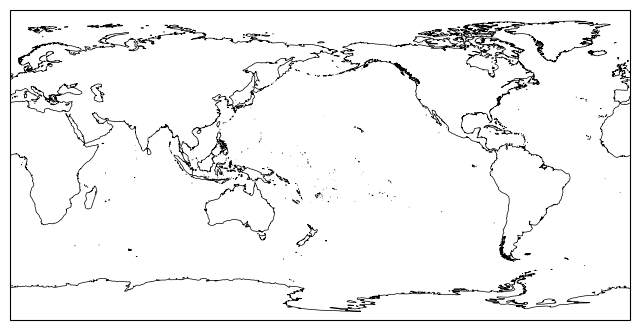

In [40]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(projection=ccrs.PlateCarree(central_longitude=180))
ax.coastlines(resolution='50m', color='black', linewidth=0.5)
lag1_ds.sel(eco_region='North Cascades').corr.plot(ax=ax,
                                   cmap='RdBu_r',
                                   vmin=-0.5, vmax=0.5,
                                   transform=ccrs.PlateCarree(),
                                   cbar_kwargs=cbar_kwargs)
sub2 = wus_eco[wus_eco['NA_L3NAME']=='North Cascades']
sub2.boundary.plot(ax=ax, color='b', linewidth=0.5)
ax.set_title('')
ax.set_title('North Cascades - Lag 1', loc='left')

ax.set_xticks([180, 220, 260], crs=ccrs.PlateCarree())
ax.set_yticks([-15, 0, 15, 30, 45, 60], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.set_ylabel('')
ax.set_xlabel('')
plt.tight_layout()


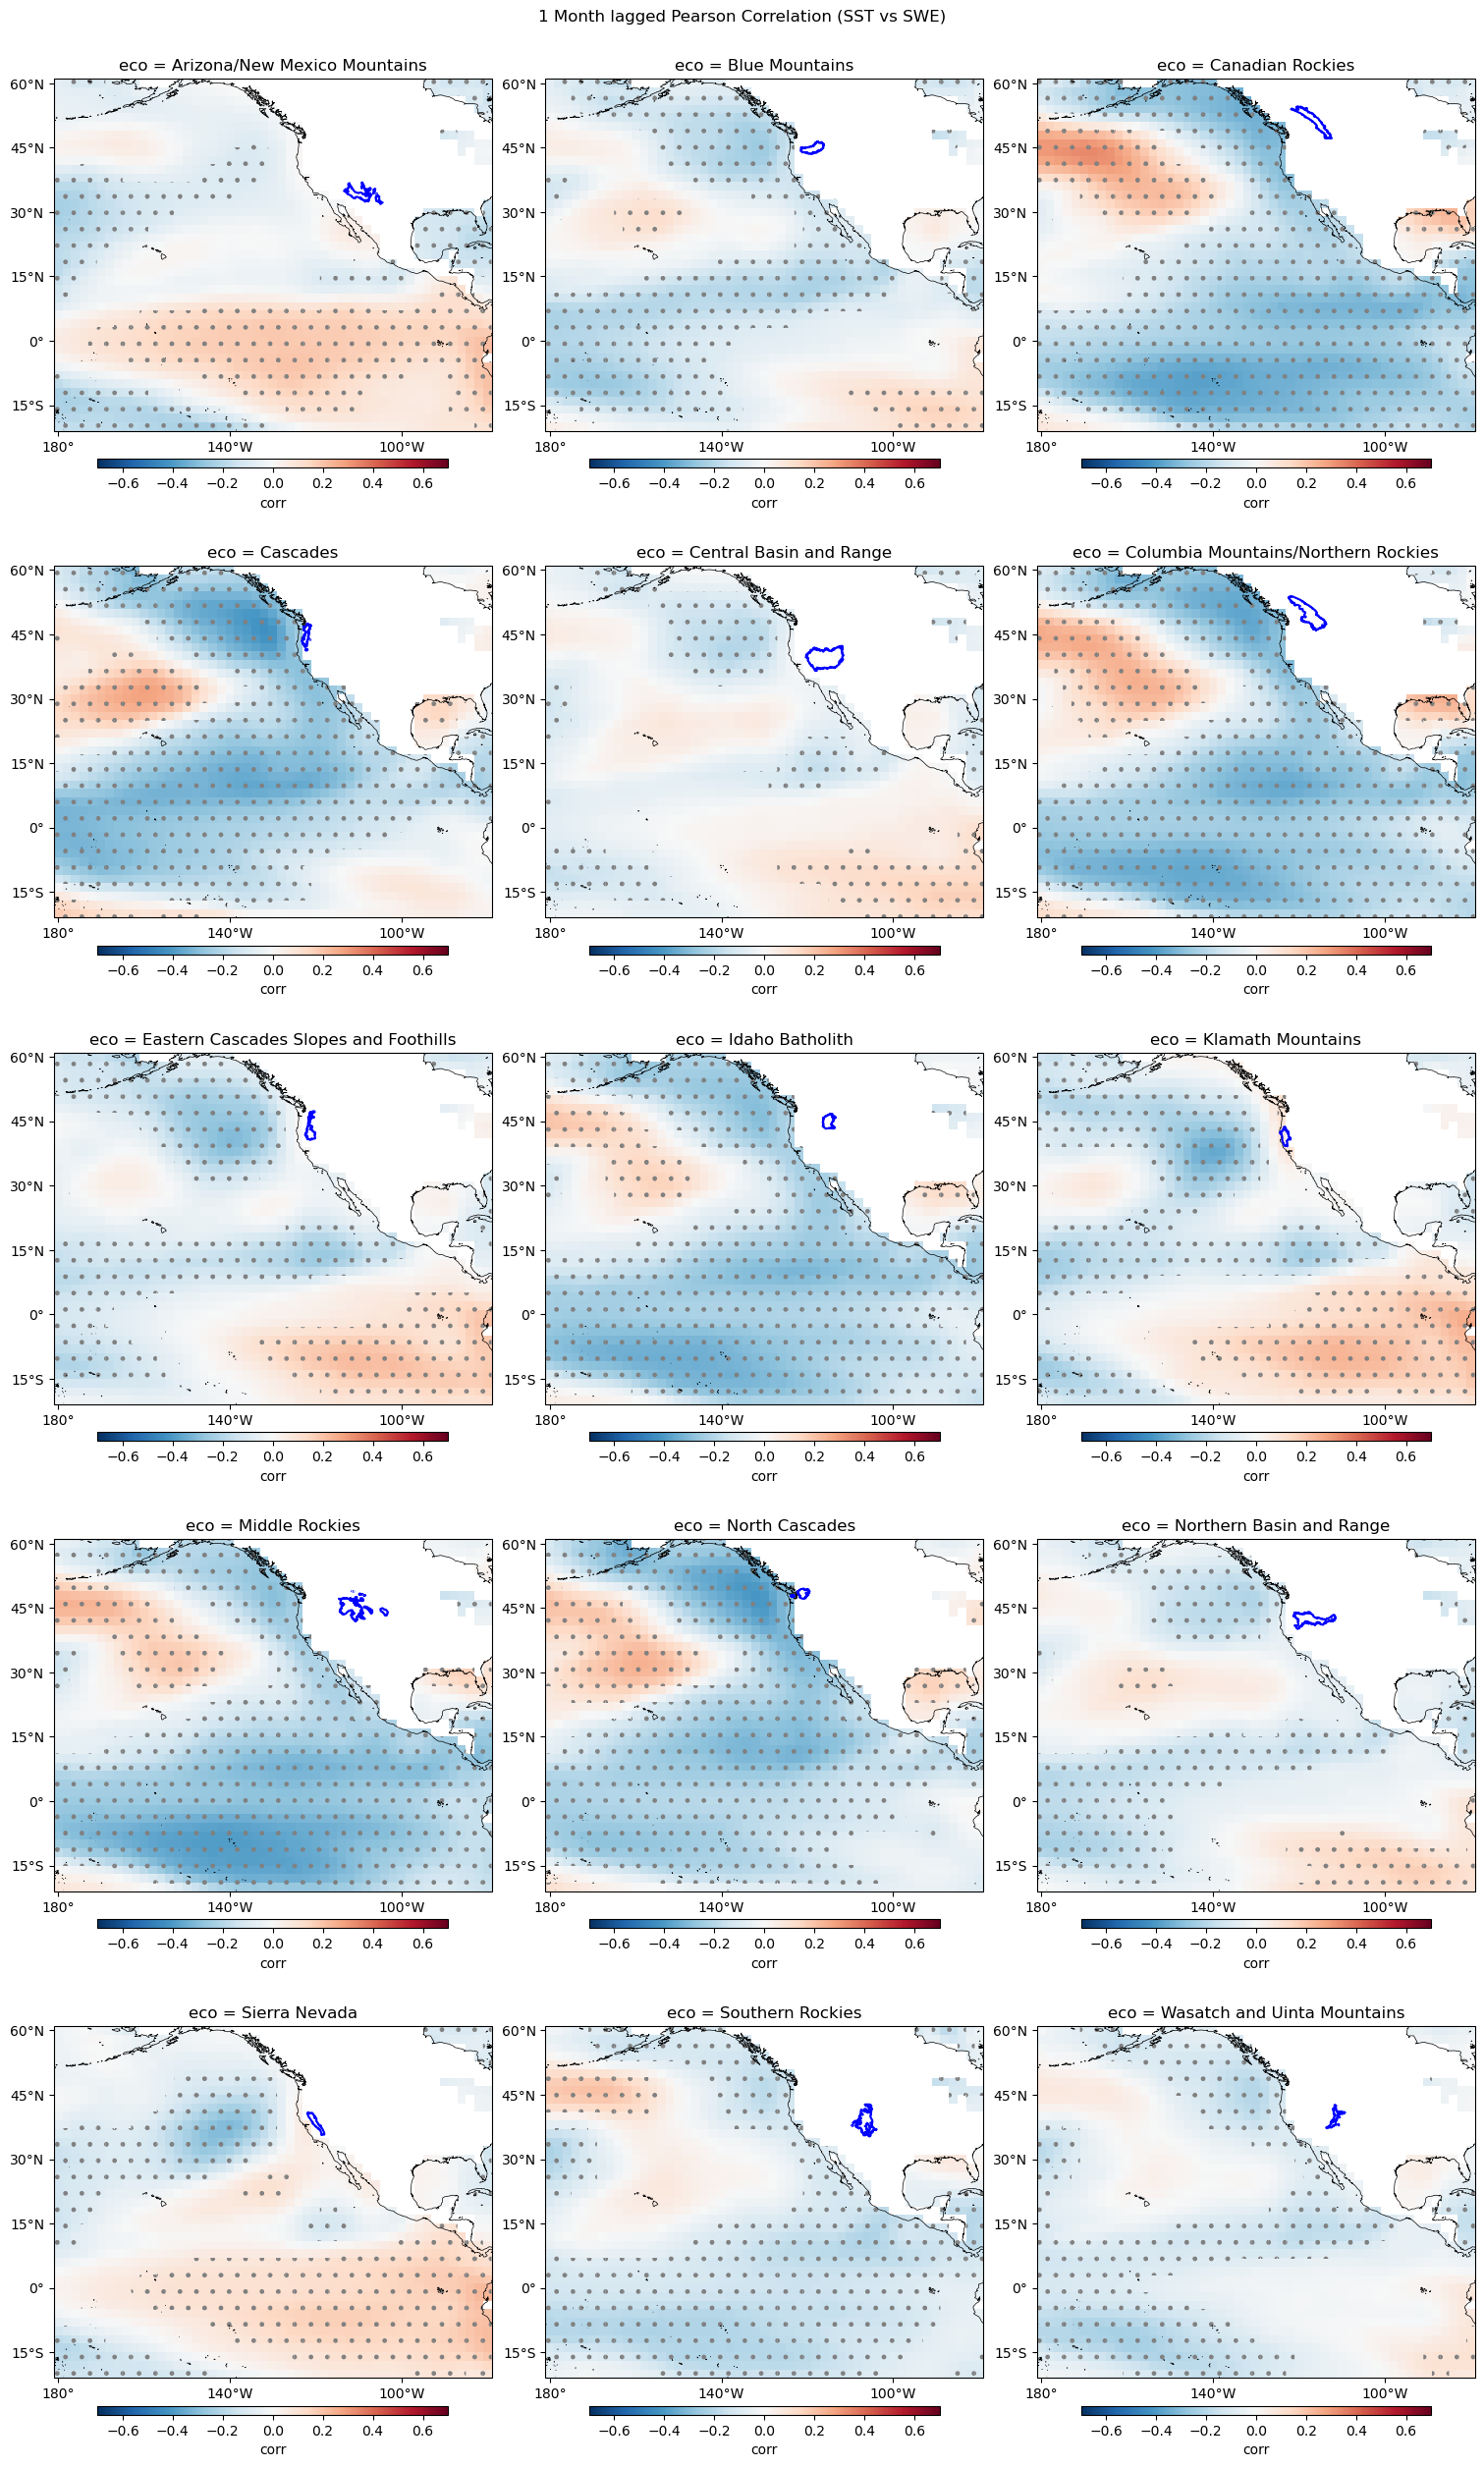

In [155]:
fig = plt.figure(figsize=(15, 25), constrained_layout=True)
# create gridspec
gs = fig.add_gridspec(5,3, height_ratios=[1,1,1,1,1],
                      width_ratios=[1,1,1])

cbar_kwargs = {'shrink':0.8, 'aspect':40,
               'orientation':'horizontal', 'pad':0.01}

for i in range(15):
    eco_name = ds.isel(eco=i).eco.values
    sub = wus_eco[wus_eco['NA_L3NAME']==eco_name]

    sig = np.ma.masked_greater_equal(lag1_ds.isel(eco=i).pval.values,0.05)
    ax = fig.add_subplot(gs[i],
                         projection=ccrs.PlateCarree(central_longitude=180))
    ax.coastlines(resolution='50m', color='black', linewidth=0.5)
    # ccm_xr.isel(eco_region=i).rho.plot(ax=ax,                                       
    #                                    cmap='RdBu_r',
    #                                    vmin=-0.7, vmax=0.7,
    #                                    transform=ccrs.PlateCarree(),
    #                                    cbar_kwargs=cbar_kwargs)
    lag1_ds.isel(eco=i).corr.plot(
        ax=ax,
        cmap='RdBu_r',
        vmin=-0.7, vmax=0.7,
        transform=ccrs.PlateCarree(),
        cbar_kwargs=cbar_kwargs)
    sub.boundary.plot(ax=ax, color='b')
    ax.pcolor(lons, lats, sig, hatch='.', alpha=0, transform=ccrs.PlateCarree())
    # ax.set_title('')
    # ax.set_title('{}) {}'.format(alc[i], eco_name), loc='left', fontsize='small')

    ax.set_xticks([180, 220, 260], crs=ccrs.PlateCarree())
    ax.set_yticks([-15, 0, 15, 30, 45, 60], crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.set_ylabel('')
    ax.set_xlabel('')
plt.suptitle('1 Month lagged Pearson Correlation (SST vs SWE)')
plt.savefig('./figs/corr_sst_swe_lag1.png', bbox_inches='tight', facecolor='w')
plt.show()

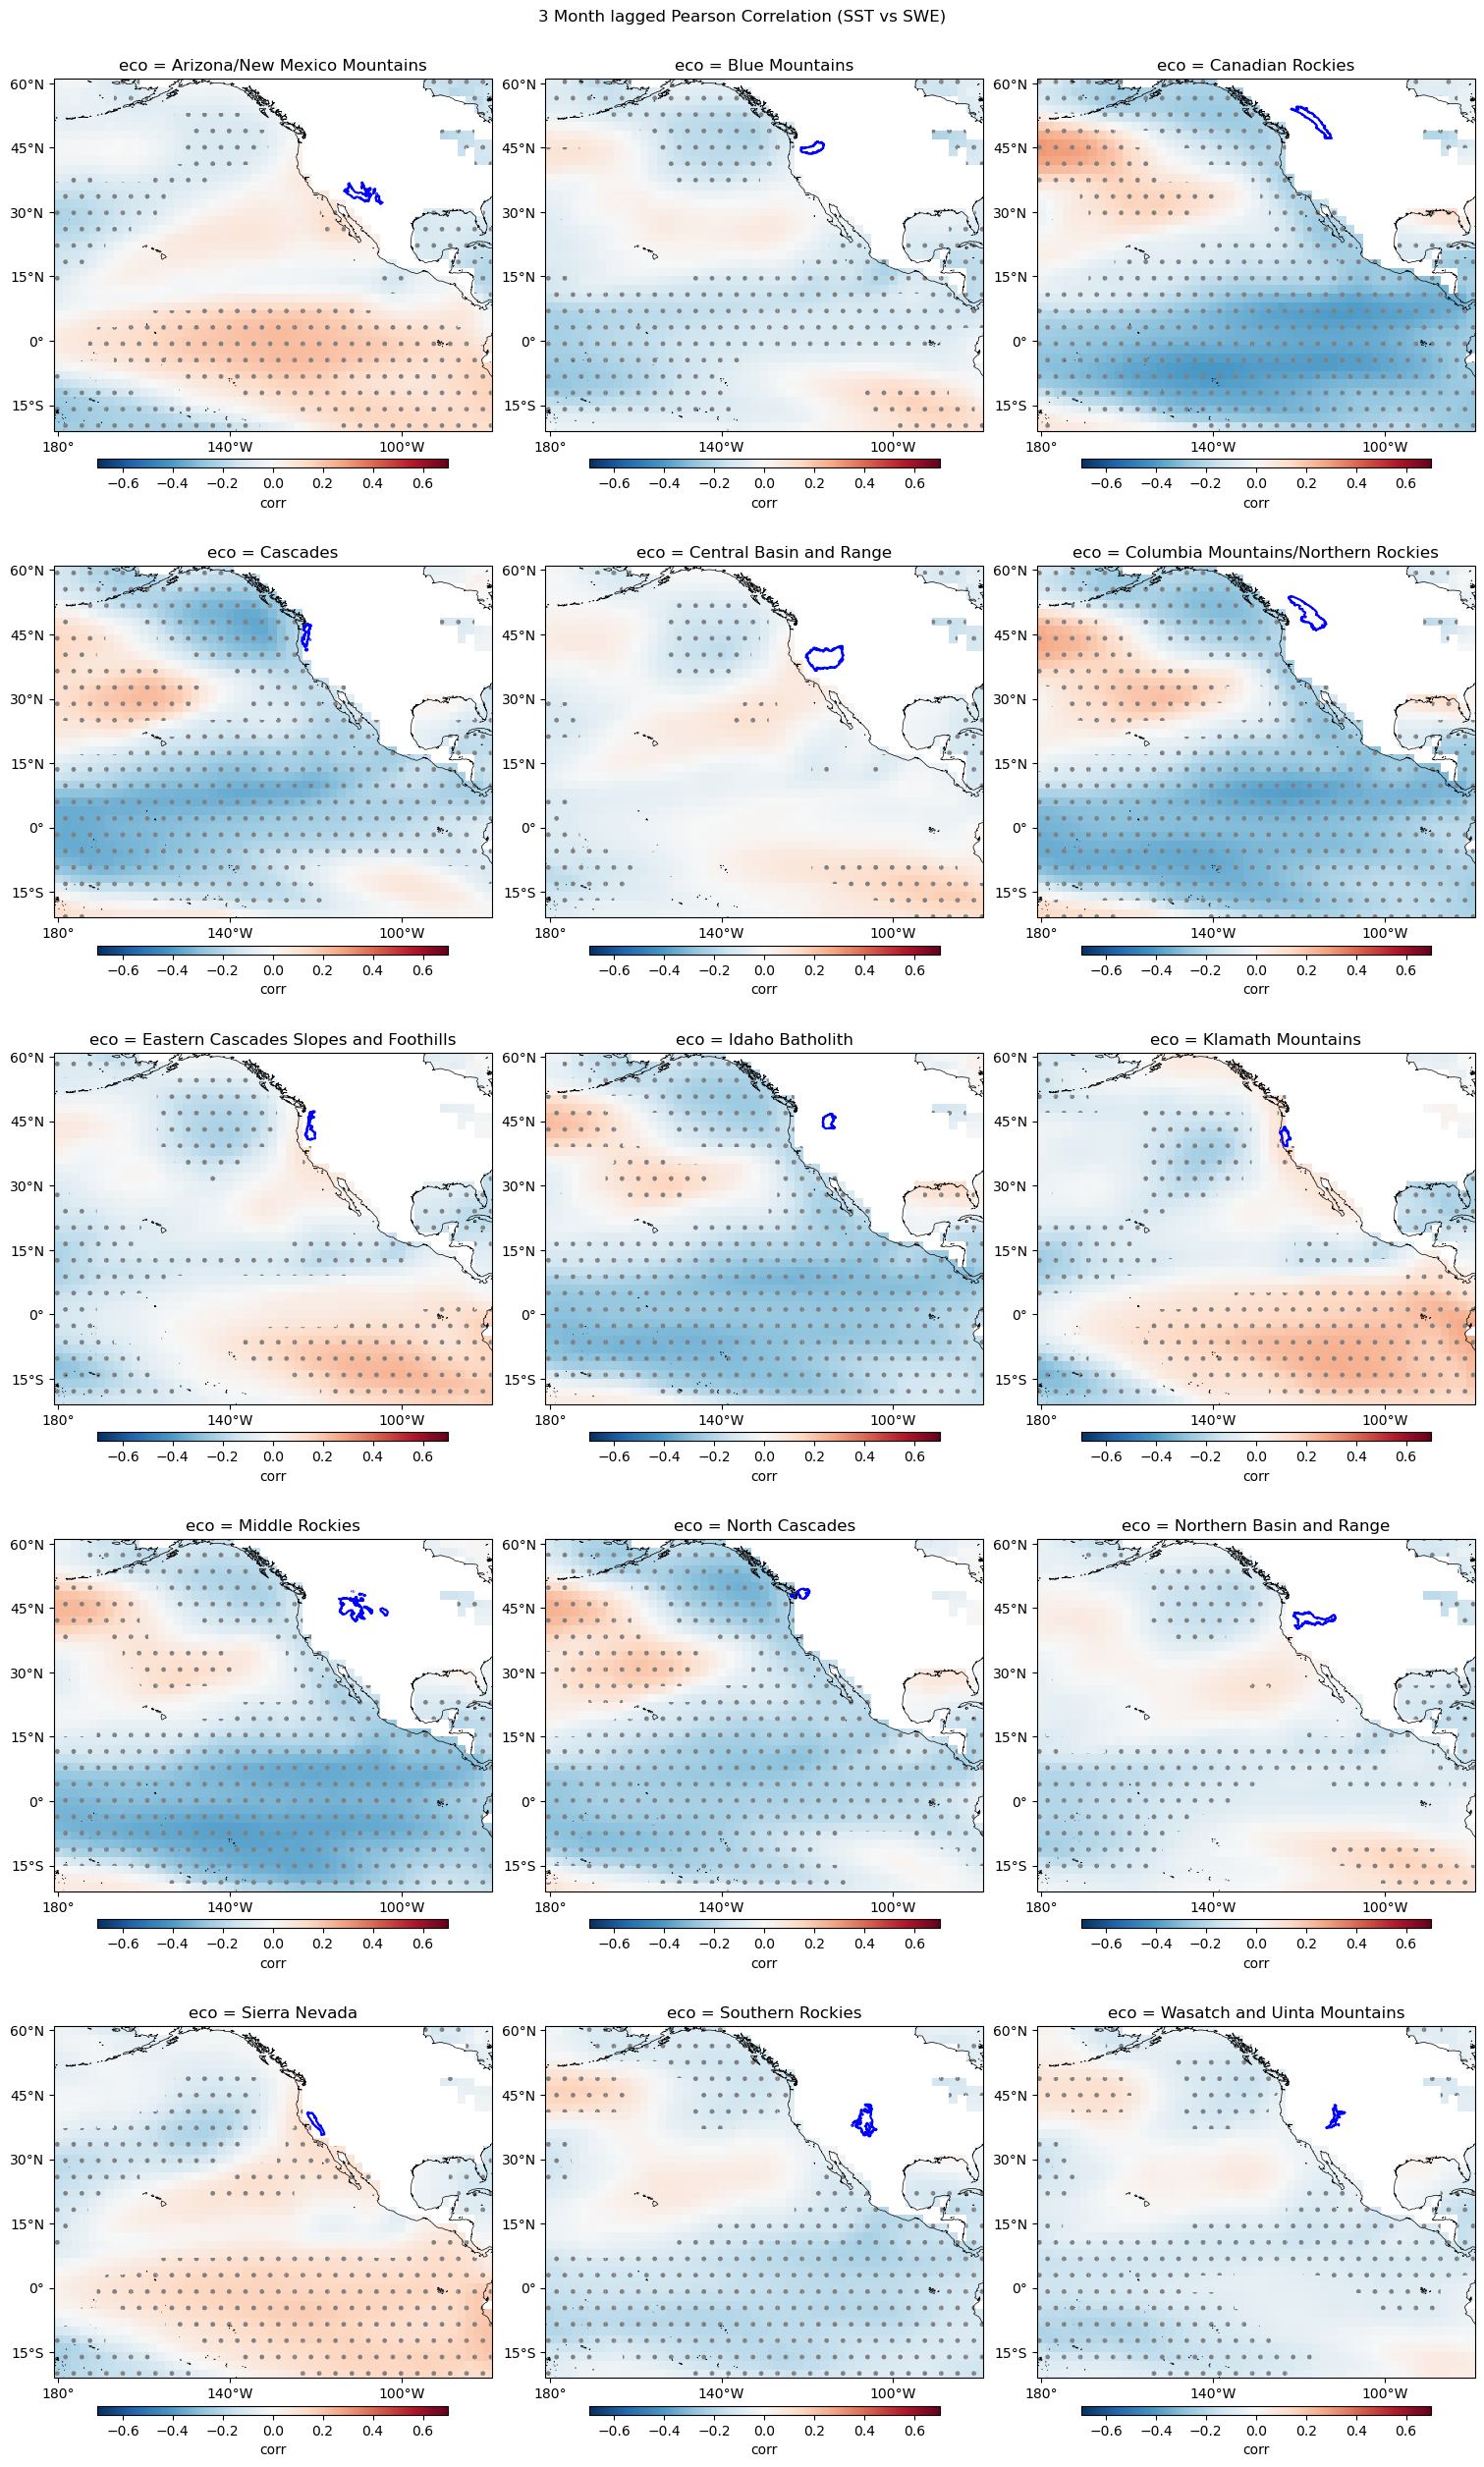

In [158]:
fig = plt.figure(figsize=(15, 25), constrained_layout=True)
# create gridspec
gs = fig.add_gridspec(5,3, height_ratios=[1,1,1,1,1],
                      width_ratios=[1,1,1])

cbar_kwargs = {'shrink':0.8, 'aspect':40,
               'orientation':'horizontal', 'pad':0.01}

for i in range(15):
    eco_name = ds.isel(eco=i).eco.values
    sub = wus_eco[wus_eco['NA_L3NAME']==eco_name]
    
    ax = fig.add_subplot(gs[i],
                         projection=ccrs.PlateCarree(central_longitude=180))
    ax.coastlines(resolution='50m', color='black', linewidth=0.5)
    # ccm_xr.isel(eco_region=i).rho.plot(ax=ax,                                       
    #                                    cmap='RdBu_r',
    #                                    vmin=-0.7, vmax=0.7,
    #                                    transform=ccrs.PlateCarree(),
    #                                    cbar_kwargs=cbar_kwargs)
    lag3_ds.isel(eco=i).corr.plot(
        ax=ax,
        cmap='RdBu_r',
        vmin=-0.7, vmax=0.7,
        transform=ccrs.PlateCarree(),
        cbar_kwargs=cbar_kwargs)
    sub.boundary.plot(ax=ax, color='b')
    sig = np.ma.masked_greater_equal(lag3_ds.isel(eco=i).pval.values,0.05)
    ax.pcolor(lons, lats, sig, hatch='.', alpha=0, transform=ccrs.PlateCarree())
    # ax.set_title('')
    # ax.set_title('{}) {}'.format(alc[i], eco_name), loc='left', fontsize='small')

    ax.set_xticks([180, 220, 260], crs=ccrs.PlateCarree())
    ax.set_yticks([-15, 0, 15, 30, 45, 60], crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.set_ylabel('')
    ax.set_xlabel('')
plt.suptitle('3 Month lagged Pearson Correlation (SST vs SWE)')
plt.savefig('./figs/corr_sst_swe_lag3.png', bbox_inches='tight', facecolor='w')
plt.show()

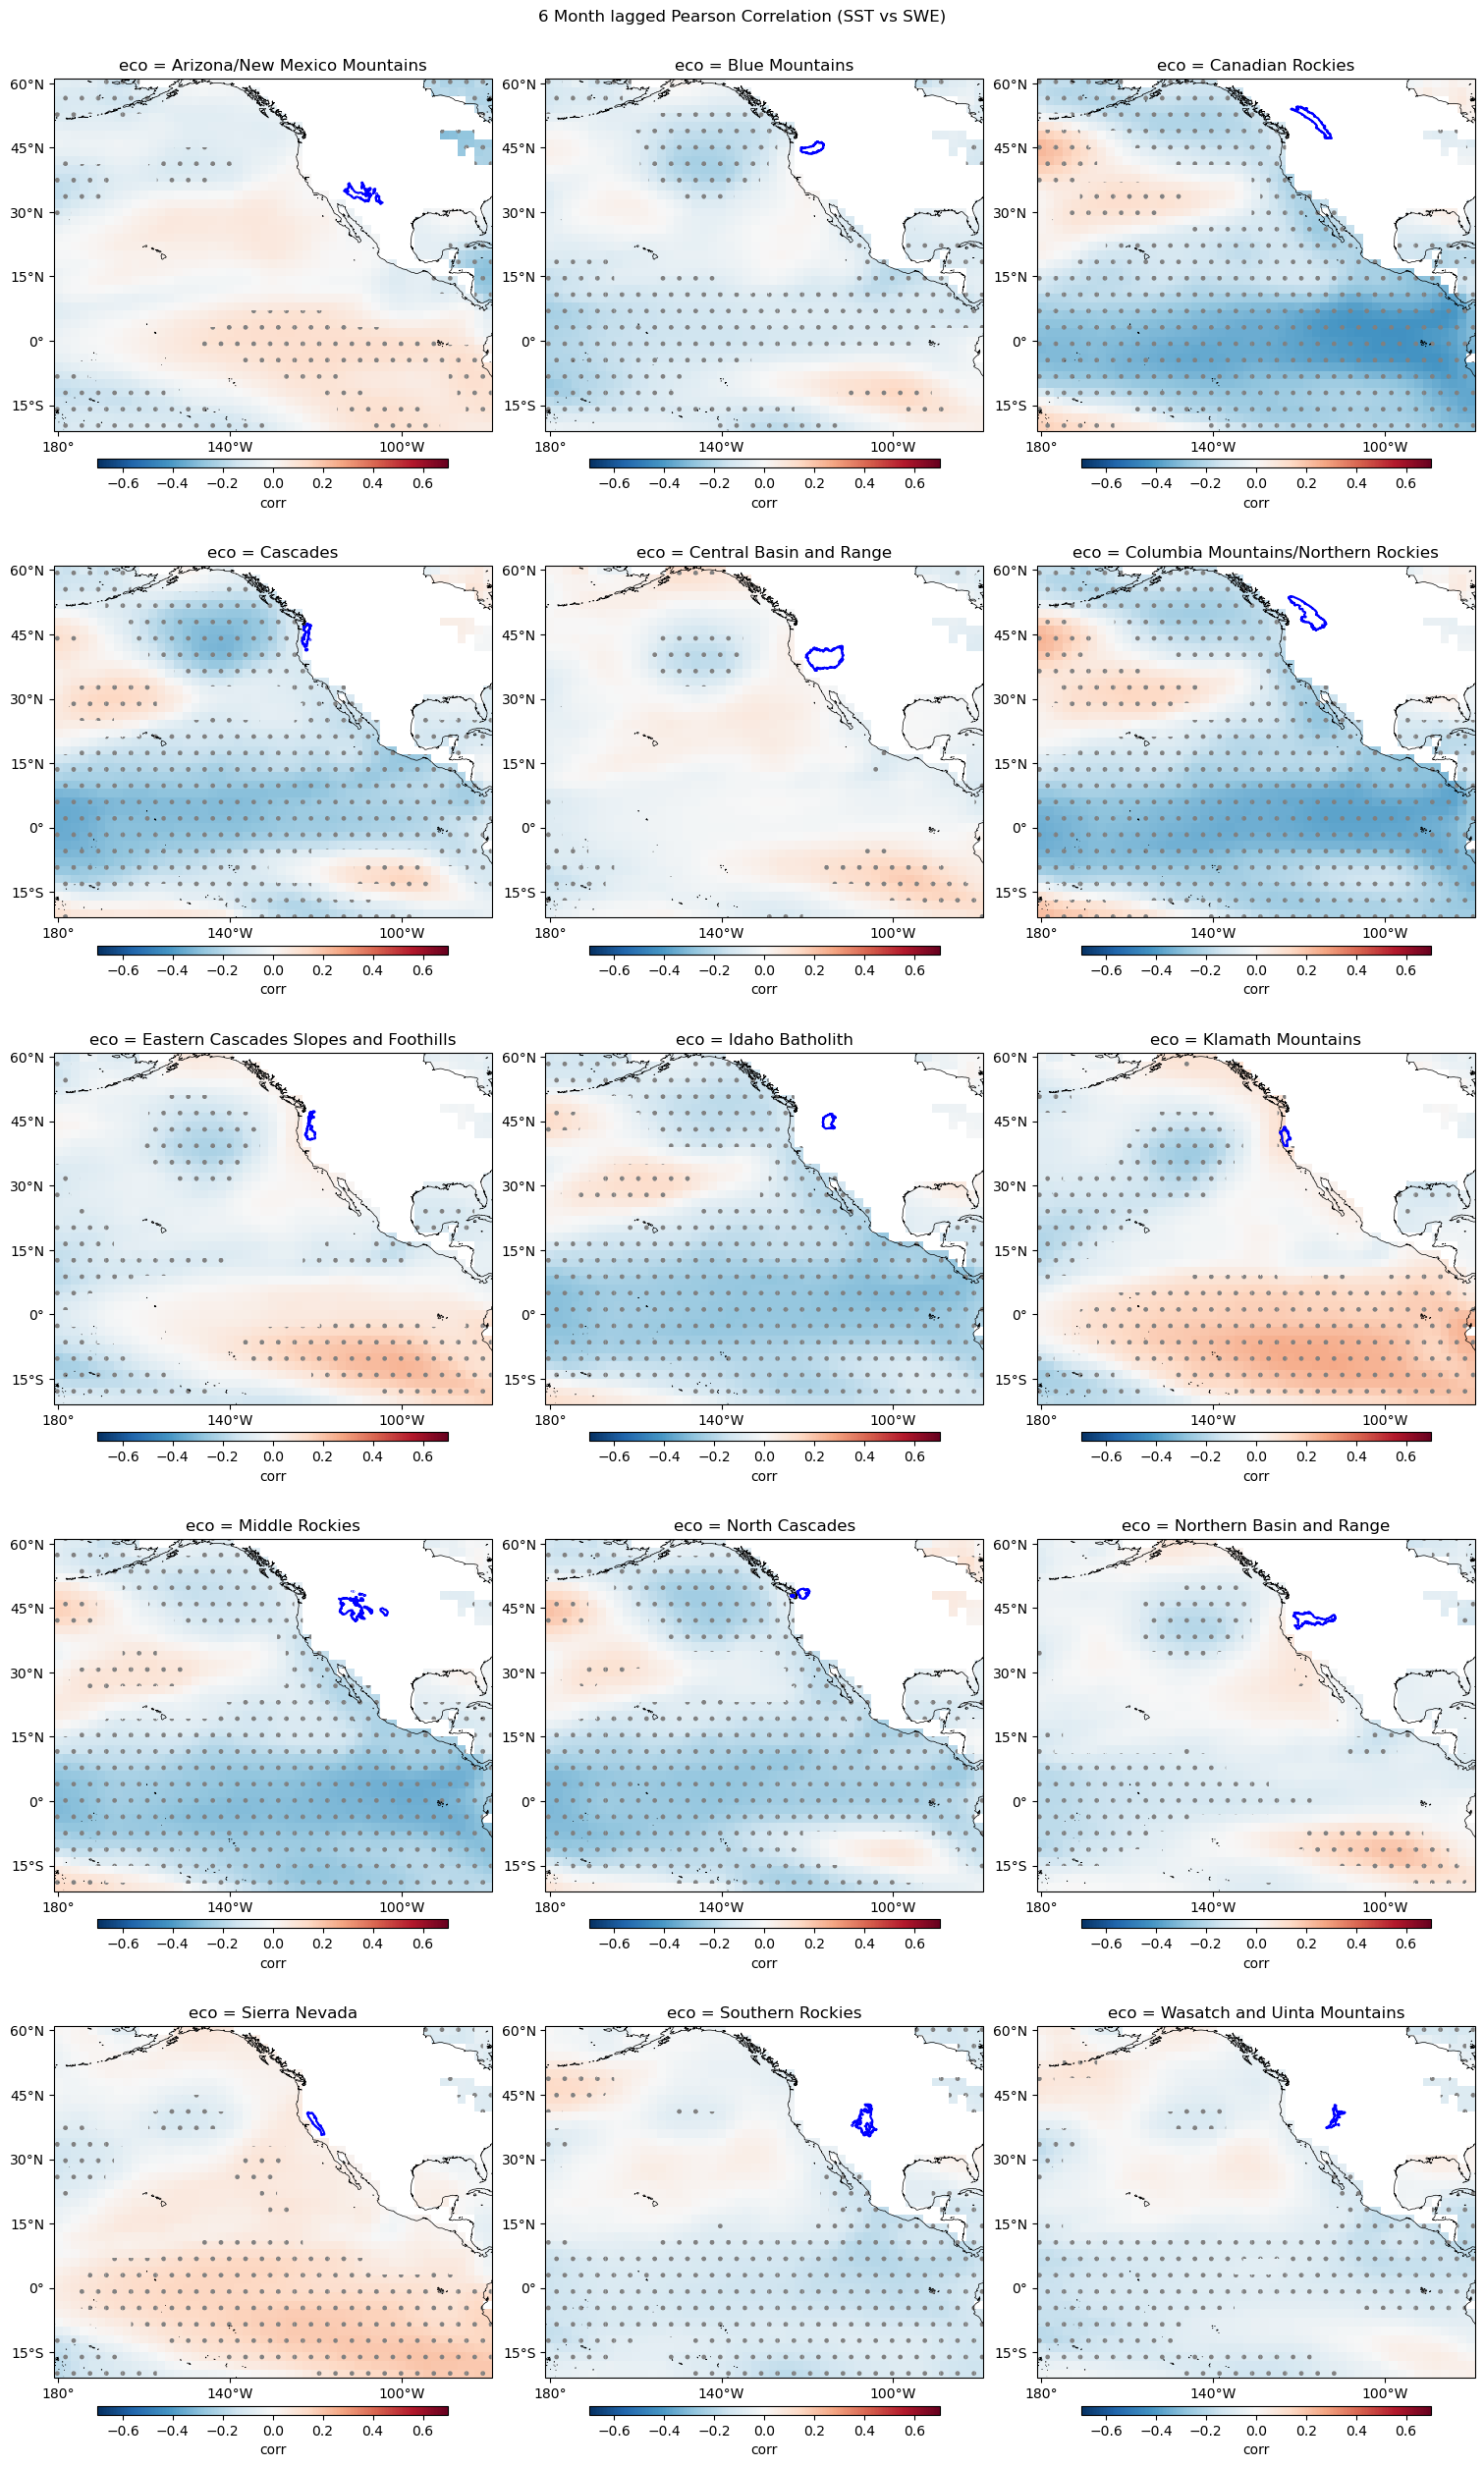

In [159]:
fig = plt.figure(figsize=(15, 25), constrained_layout=True)
# create gridspec
gs = fig.add_gridspec(5,3, height_ratios=[1,1,1,1,1],
                      width_ratios=[1,1,1])

cbar_kwargs = {'shrink':0.8, 'aspect':40,
               'orientation':'horizontal', 'pad':0.01}

for i in range(15):
    eco_name = ds.isel(eco=i).eco.values
    sub = wus_eco[wus_eco['NA_L3NAME']==eco_name]
    
    ax = fig.add_subplot(gs[i],
                         projection=ccrs.PlateCarree(central_longitude=180))
    ax.coastlines(resolution='50m', color='black', linewidth=0.5)
    # ccm_xr.isel(eco_region=i).rho.plot(ax=ax,                                       
    #                                    cmap='RdBu_r',
    #                                    vmin=-0.7, vmax=0.7,
    #                                    transform=ccrs.PlateCarree(),
    #                                    cbar_kwargs=cbar_kwargs)
    lag6_ds.isel(eco=i).corr.plot(
        ax=ax,
        cmap='RdBu_r',
        vmin=-0.7, vmax=0.7,
        transform=ccrs.PlateCarree(),
        cbar_kwargs=cbar_kwargs)
    sub.boundary.plot(ax=ax, color='b')
    sig = np.ma.masked_greater_equal(lag6_ds.isel(eco=i).pval.values,0.05)
    ax.pcolor(lons, lats, sig, hatch='.', alpha=0, transform=ccrs.PlateCarree())
    # ax.set_title('')
    # ax.set_title('{}) {}'.format(alc[i], eco_name), loc='left', fontsize='small')

    ax.set_xticks([180, 220, 260], crs=ccrs.PlateCarree())
    ax.set_yticks([-15, 0, 15, 30, 45, 60], crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.set_ylabel('')
    ax.set_xlabel('')
plt.suptitle('6 Month lagged Pearson Correlation (SST vs SWE)')
plt.savefig('./figs/corr_sst_swe_lag6.png', bbox_inches='tight', facecolor='w')
plt.show()